In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T135233Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D34705e68b0632e63c30afd75ba4ef7dd184a5b04709cd3666297be6614b50416f4a671e52148155b4e5dffab96d21fe950552c14d713b6a4ca9d0056e3624e3af3d0fa832882891e290fa52468cafba717f83ca533f1cb9de1963910dee281e67c1c1e479feefe241b4e40eae99e419795097ec57f7e1e2b8b9610e0df1a1aa50835c70fe514ae2a258460b7173766fd0502708724e74475ee16e24b47cf665ac7567546764e1512486092450057d5493f3ca22261eb60efd950feda8e96122bb8975c59cf4c96f093f6c2e0c172c7adc4bfb3ebff680fae4f1e500280f0c6553b477e3294688b23f0e82d0d2c23e48365f8363cb128cbe936f65a869a4615f8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


# Generative Adversarial Networks(GAN) - PyTorch Tutorial

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHwq72%2FbtqAY6E0wYb%2FBFRgtJWTY3Ij9BKks7vsM1%2Fimg.png)

This kernel is for those new to gan.

And It was coded with pytorch, and all the code was converted into the familiar Jupyter notebook form for data analysts and machine learning engineers by referring to the gan official Python code.

I hope that many Kaglers will be interested in Generative Adversarial Networks(GAN), and that it will be shared and helpful to more people. So let's get started!

## MAIN Reference
1. [PyTorch-GAN | Github/eriklindernoren | Collection of PyTorch implementations of GAN](https://github.com/sw-song/PyTorch-GAN)


## Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Configure Data Loader
Step 9. Define Optimizers
Step 10. Training
```
---

### Step 1. Import Libraries

In [2]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

### Step 2. Initial setting

In [3]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [4]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [5]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

### Step 3. Define Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

> Read More
- [What is the difference between nn.ReLU() and nn.ReLU(inplace=True)?](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)
- [Tanh](https://wiki.documentfoundation.org/Documentation/Calc_Functions/TANH)
- [Unpacking Operators in Python](https://towardsdatascience.com/unpacking-operators-in-python-306ae44cd480)

### Step 4. Define Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

> Read More
- [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)
- [pytorch in x = x.view (x.size (0), -1) understanding](https://www.programmersought.com/article/11412923760/)

### Step 5. Define Loss Function

In [8]:
adversarial_loss = torch.nn.BCELoss()

> Read More
- [BCELoss(Binary Cross Entropy Loss)](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

### Step 6. Initialize generator and Discriminator

In [9]:
generator = Generator()
discriminator = Discriminator()

In [10]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [11]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Step 7. GPU Setting

In [11]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

### Step 8. Configure Data Loader

Since we use the Kaggle dataset, it is necessary to read the csv file and convert it into an image format.


For the code to load and convert Kaggle MNIST data, I referred to [Pytorch Dataset and DataLoader](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader).


In [12]:
import pandas as pd
from torch.utils.data import Dataset

In [13]:
class DatasetMNIST(Dataset): # inherit abstract class - 'Dataset'

    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image ad ndarray type (H, W, C)
        # be carefull for converting dtype to np.uint8 (Unsigned integer (0 to 255))
        # in this example, We use ToTensor(), so we define the numpy array like (H, W, C)

        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)

        return image, label


> TEST CODE : Read CSV file

In [14]:
train = pd.read_csv('../input/digit-recognizer/train.csv')

In [16]:
train

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
41995       0  ...         0         0         0         0         0   
41996       0  ...         0         0         0         0         0   
41997       0  ...         0         0         0         0         0   
41998       0  ...         0         0         0         0         0   
41999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
41995         0         0         0         0         0  
41996         0         0         0         0         0  
41997         0         0         0         0         0  
41998         0         0         0         0         0  
41999         0         0         0         0         0  

[42000 rows x 785 columns]

> TEST CODE : Construct image from csv file

In [15]:
for index in range(1, 6): # N : 5 (Number of Image)
    temp_image = train.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
    temp_label = train.iloc[index, 0]
    print('Shape of Image : ',temp_image.shape)
    print('label : ', temp_label)

Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  1
Shape of Image :  (28, 28, 1)
label :  4
Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  0


> TEST CODE : transform from table data to image data with basic preprocessing

In [16]:
dataset = DatasetMNIST(file_path='../input/digit-recognizer/train.csv',
                       transform=transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]
                       ))

In [17]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [18]:
temp_img.size() # before ToTensor() : (28,28,1), after : (1,28,28)

torch.Size([1, 28, 28])

In [19]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

> TEST CODE : Define dataloader that can load image by batch

In [20]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [21]:
temp_images, _ = next(iter(dataloader)) # We don't use label, so _
print('images shape on batch size = {}'.format(temp_images.size()))

images shape on batch size = torch.Size([64, 1, 28, 28])


> Read More
1. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
    - .ToTensor | Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
    - .ToTensor | Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

### Step 9. Define optimizers

In [22]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [23]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

### Step 10. Training

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpMdme%2FbtqA1ArBCOy%2FqqGg7IvV0hpqVkvBuEFpJK%2Fimg.png)

In [24]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [25]:
from tqdm.notebook import tqdm

In [26]:
# Visualize result
import matplotlib.pyplot as plt

  0%|          | 0/657 [00:00<?, ?it/s]

<ipython-input-27-d3fbdea7b795>:7: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE


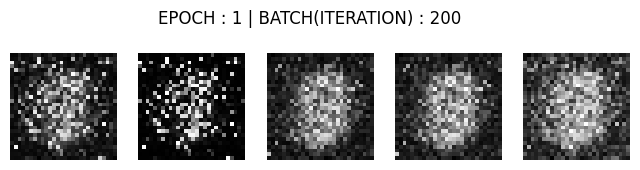

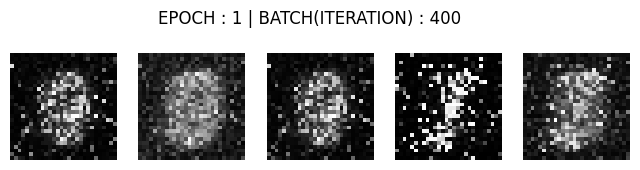

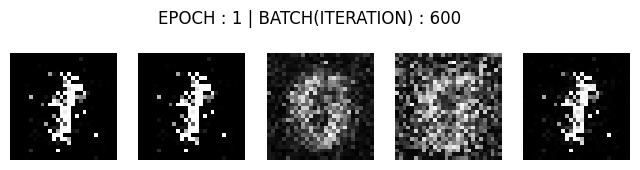

[Epoch: 1/100] [Batch: 657/657] [D loss: 0.381941] [G loss: 1.139429]


  0%|          | 0/657 [00:00<?, ?it/s]

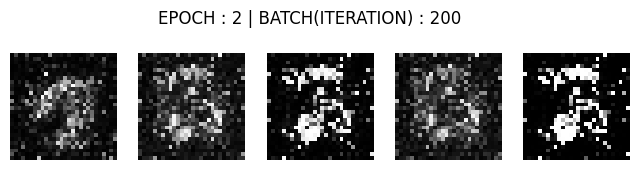

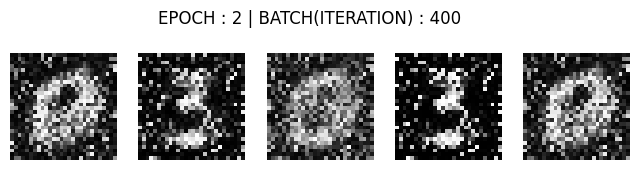

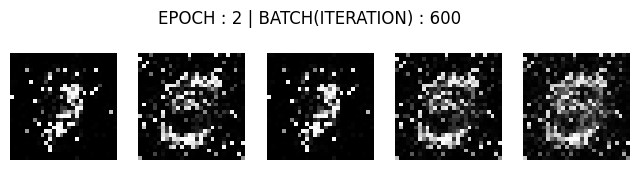

[Epoch: 2/100] [Batch: 657/657] [D loss: 0.325217] [G loss: 1.179470]


  0%|          | 0/657 [00:00<?, ?it/s]

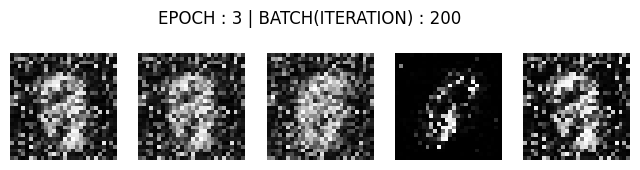

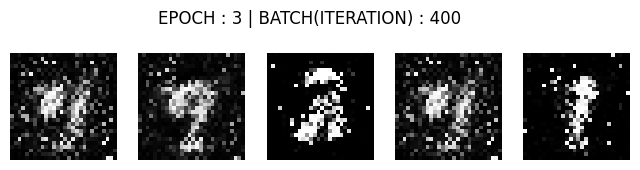

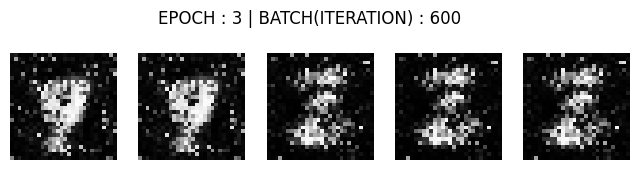

[Epoch: 3/100] [Batch: 657/657] [D loss: 0.321385] [G loss: 1.504774]


  0%|          | 0/657 [00:00<?, ?it/s]

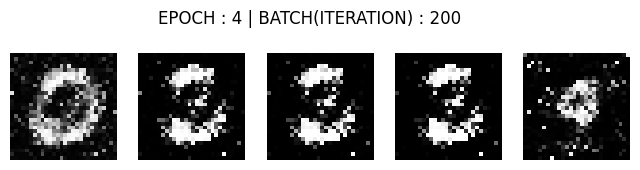

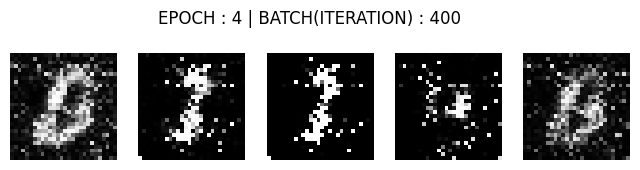

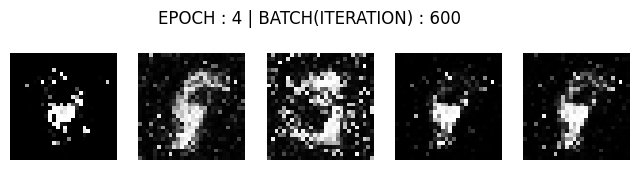

[Epoch: 4/100] [Batch: 657/657] [D loss: 0.180985] [G loss: 2.195315]


  0%|          | 0/657 [00:00<?, ?it/s]

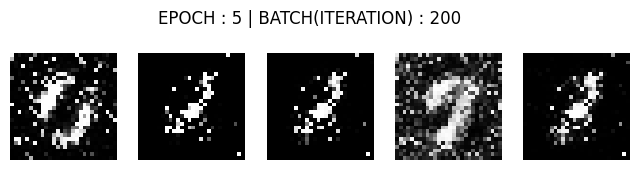

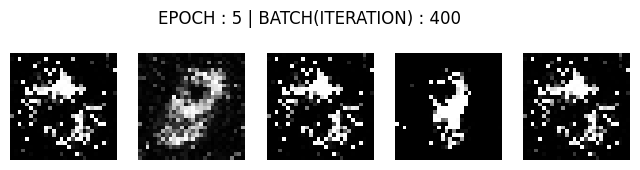

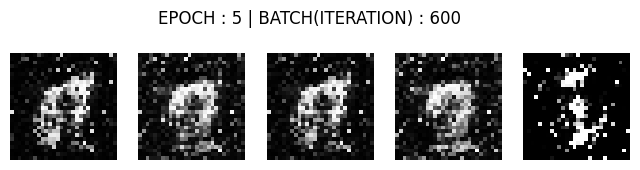

[Epoch: 5/100] [Batch: 657/657] [D loss: 0.428961] [G loss: 1.292383]


  0%|          | 0/657 [00:00<?, ?it/s]

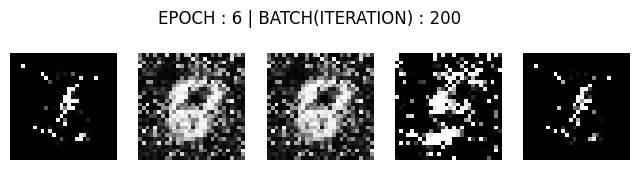

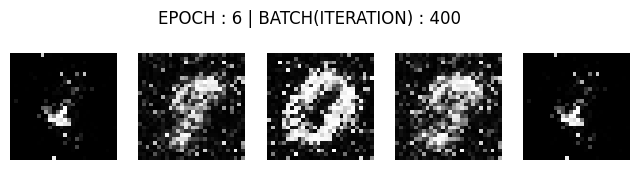

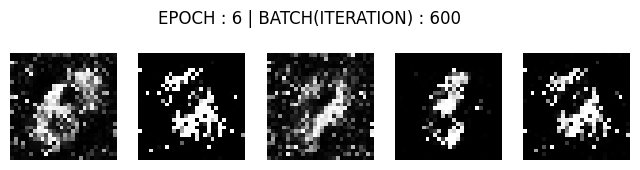

[Epoch: 6/100] [Batch: 657/657] [D loss: 0.253018] [G loss: 1.530810]


  0%|          | 0/657 [00:00<?, ?it/s]

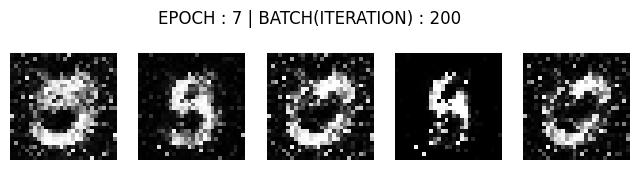

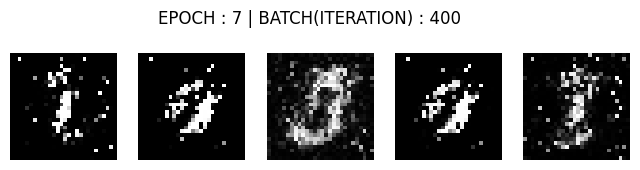

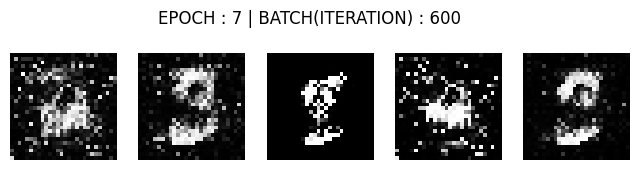

[Epoch: 7/100] [Batch: 657/657] [D loss: 0.621273] [G loss: 0.499957]


  0%|          | 0/657 [00:00<?, ?it/s]

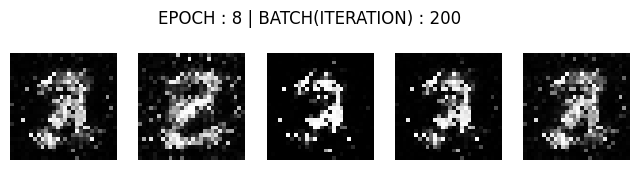

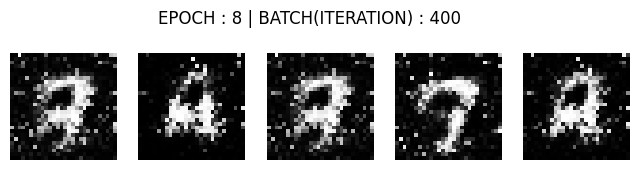

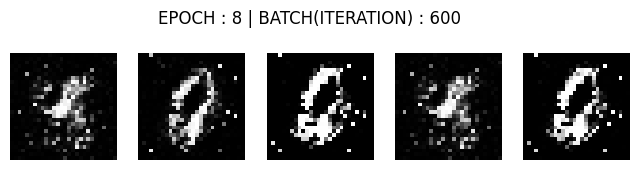

[Epoch: 8/100] [Batch: 657/657] [D loss: 0.149364] [G loss: 1.856603]


  0%|          | 0/657 [00:00<?, ?it/s]

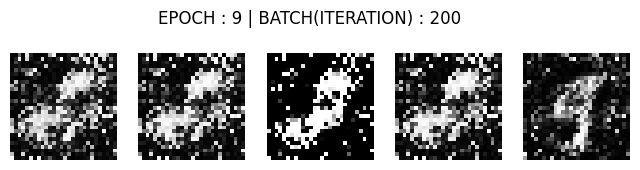

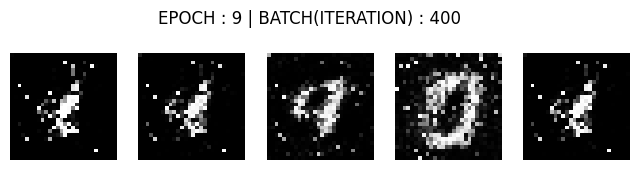

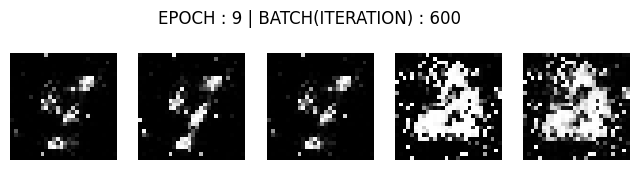

[Epoch: 9/100] [Batch: 657/657] [D loss: 0.219851] [G loss: 2.171903]


  0%|          | 0/657 [00:00<?, ?it/s]

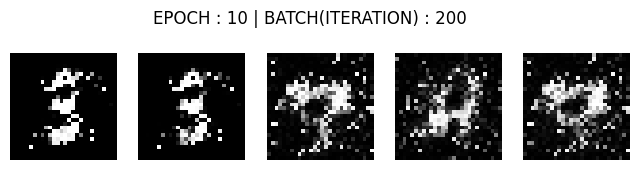

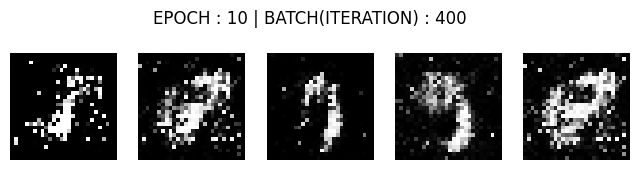

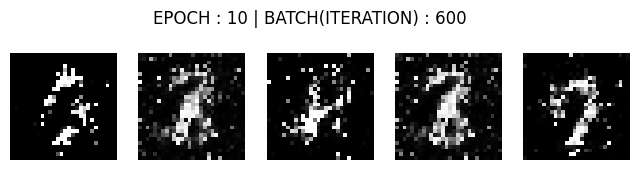

[Epoch: 10/100] [Batch: 657/657] [D loss: 0.215281] [G loss: 1.591745]


  0%|          | 0/657 [00:00<?, ?it/s]

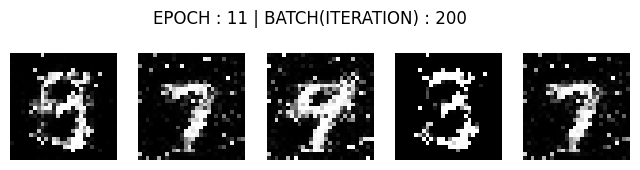

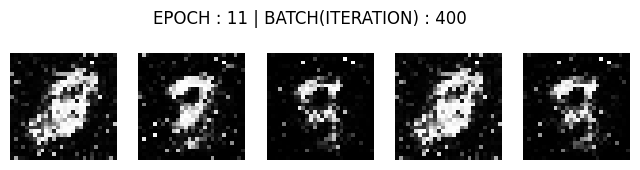

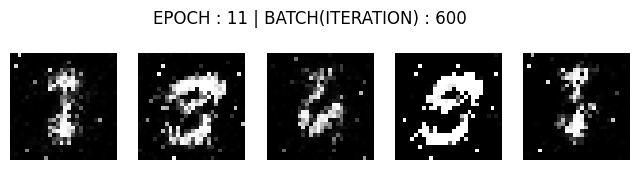

[Epoch: 11/100] [Batch: 657/657] [D loss: 0.489934] [G loss: 4.412972]


  0%|          | 0/657 [00:00<?, ?it/s]

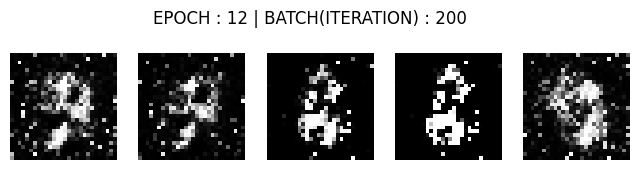

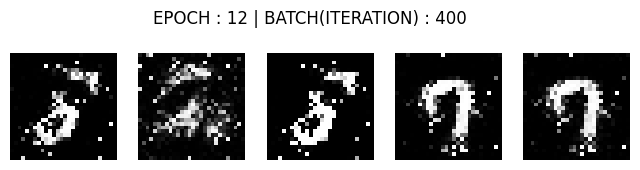

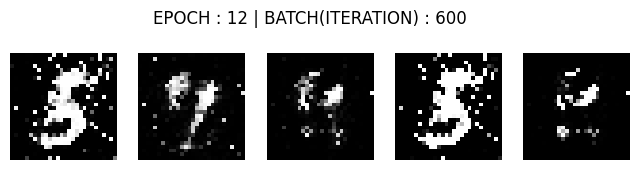

[Epoch: 12/100] [Batch: 657/657] [D loss: 0.304793] [G loss: 1.170270]


  0%|          | 0/657 [00:00<?, ?it/s]

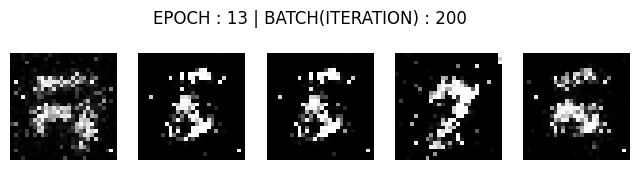

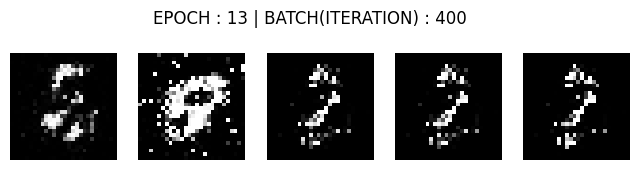

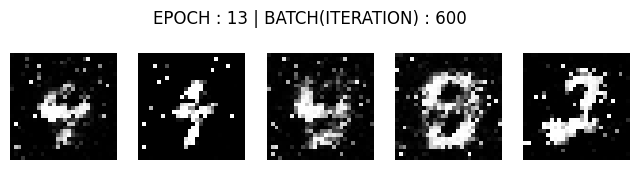

[Epoch: 13/100] [Batch: 657/657] [D loss: 0.343023] [G loss: 2.520512]


  0%|          | 0/657 [00:00<?, ?it/s]

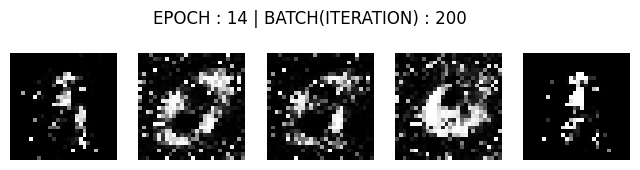

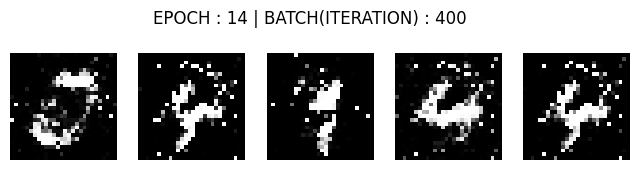

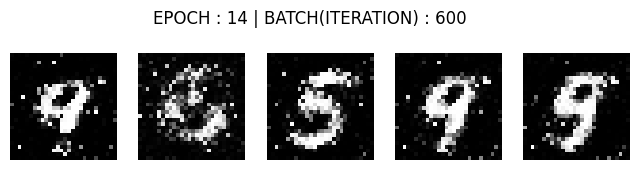

[Epoch: 14/100] [Batch: 657/657] [D loss: 0.279172] [G loss: 1.068572]


  0%|          | 0/657 [00:00<?, ?it/s]

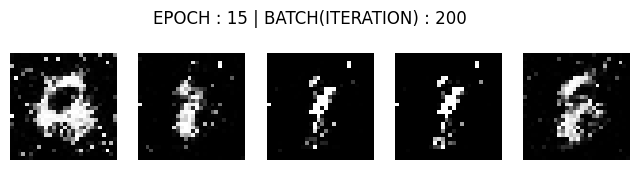

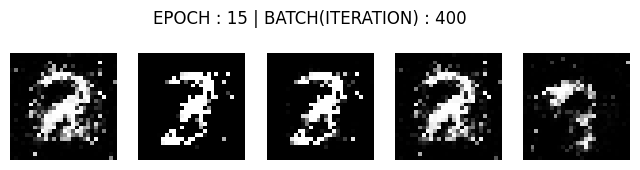

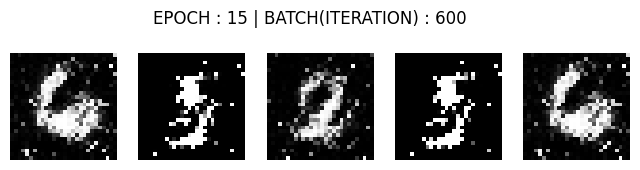

[Epoch: 15/100] [Batch: 657/657] [D loss: 0.775285] [G loss: 7.947311]


  0%|          | 0/657 [00:00<?, ?it/s]

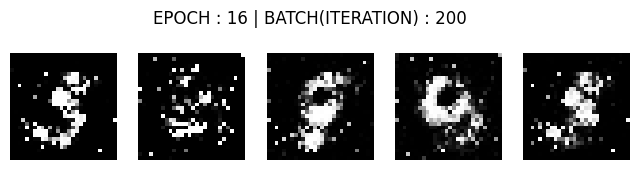

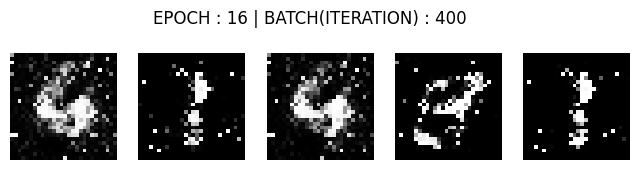

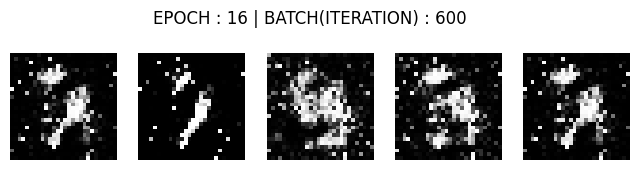

[Epoch: 16/100] [Batch: 657/657] [D loss: 0.073472] [G loss: 2.612980]


  0%|          | 0/657 [00:00<?, ?it/s]

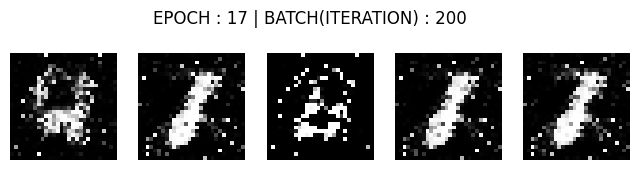

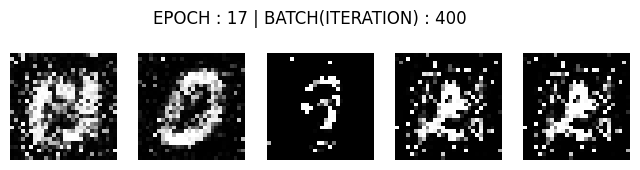

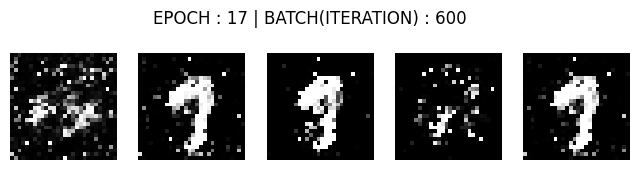

[Epoch: 17/100] [Batch: 657/657] [D loss: 0.280327] [G loss: 1.158187]


  0%|          | 0/657 [00:00<?, ?it/s]

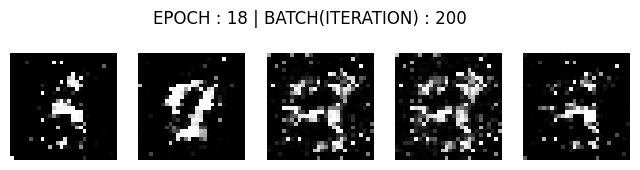

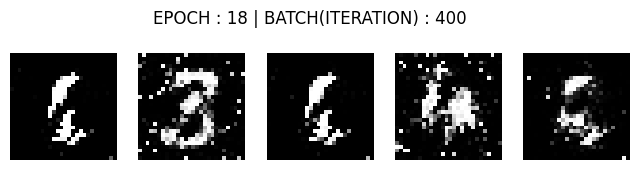

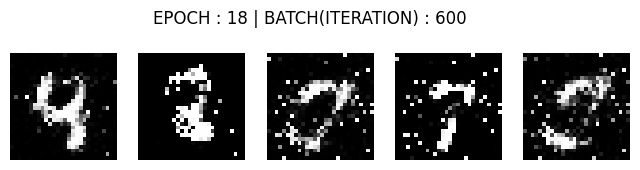

[Epoch: 18/100] [Batch: 657/657] [D loss: 0.229403] [G loss: 1.220852]


  0%|          | 0/657 [00:00<?, ?it/s]

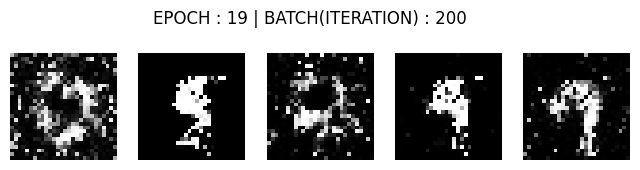

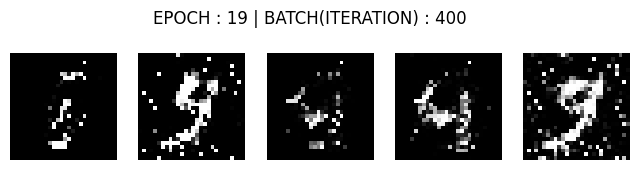

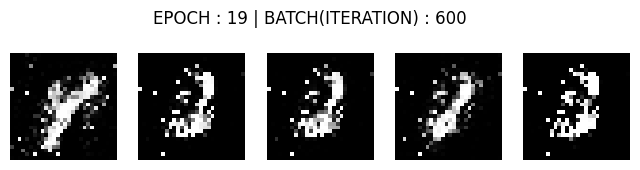

[Epoch: 19/100] [Batch: 657/657] [D loss: 0.831972] [G loss: 9.589736]


  0%|          | 0/657 [00:00<?, ?it/s]

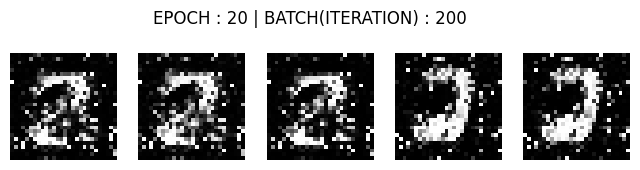

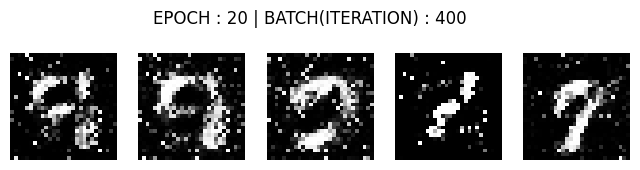

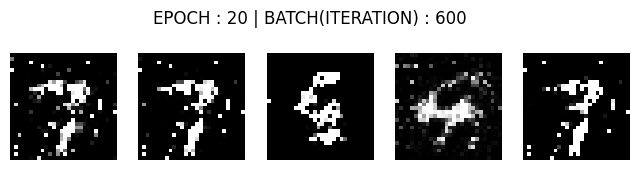

[Epoch: 20/100] [Batch: 657/657] [D loss: 0.217247] [G loss: 1.396175]


  0%|          | 0/657 [00:00<?, ?it/s]

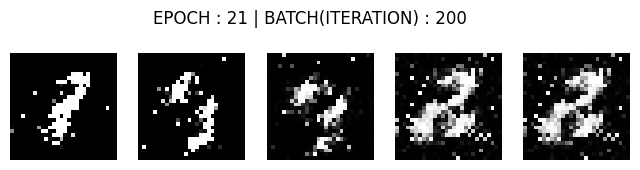

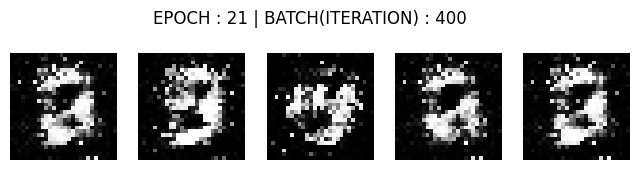

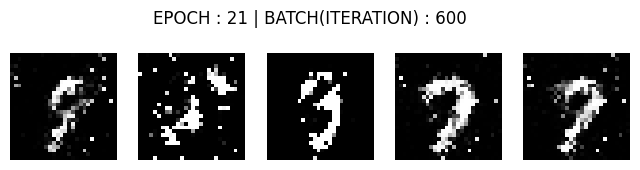

[Epoch: 21/100] [Batch: 657/657] [D loss: 0.653323] [G loss: 6.283563]


  0%|          | 0/657 [00:00<?, ?it/s]

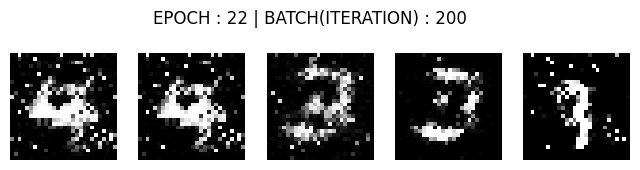

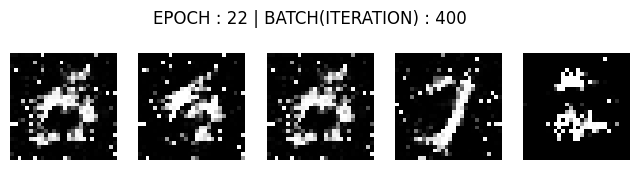

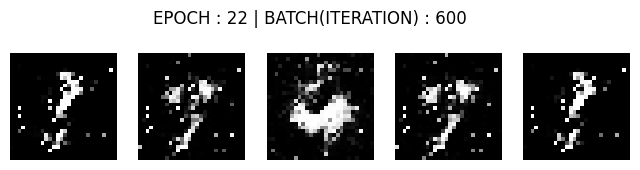

[Epoch: 22/100] [Batch: 657/657] [D loss: 0.174821] [G loss: 2.004330]


  0%|          | 0/657 [00:00<?, ?it/s]

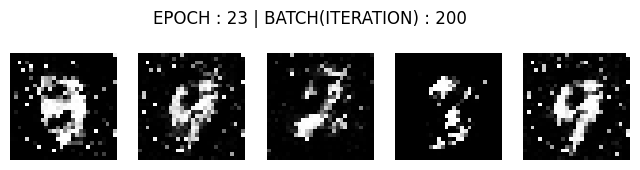

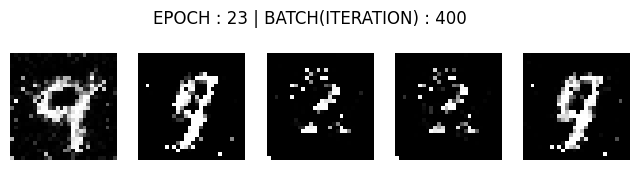

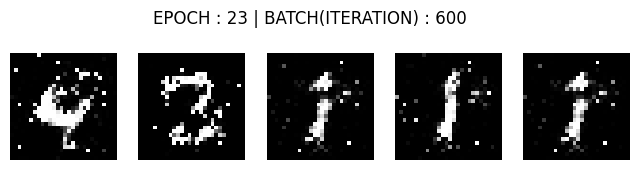

[Epoch: 23/100] [Batch: 657/657] [D loss: 0.194814] [G loss: 1.755011]


  0%|          | 0/657 [00:00<?, ?it/s]

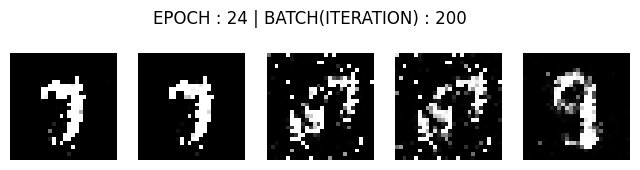

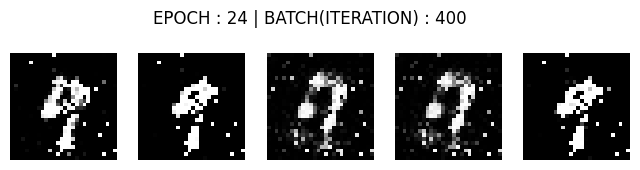

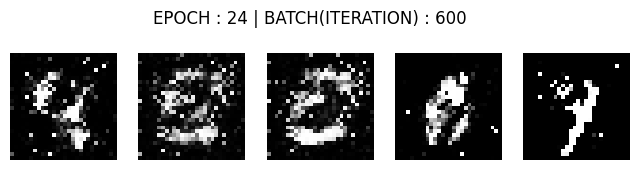

[Epoch: 24/100] [Batch: 657/657] [D loss: 0.079418] [G loss: 3.805928]


  0%|          | 0/657 [00:00<?, ?it/s]

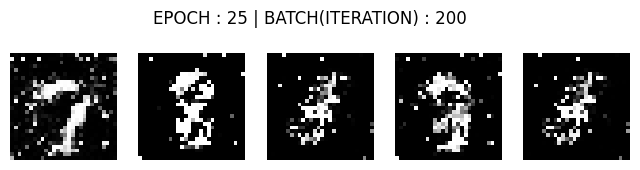

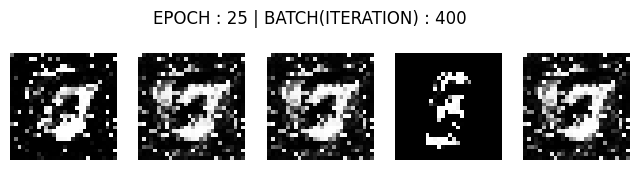

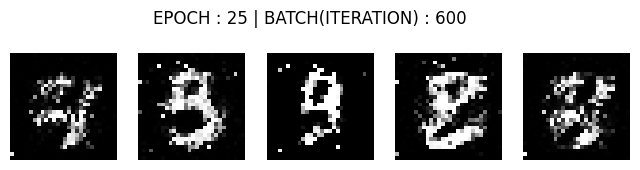

[Epoch: 25/100] [Batch: 657/657] [D loss: 0.248903] [G loss: 1.771388]


  0%|          | 0/657 [00:00<?, ?it/s]

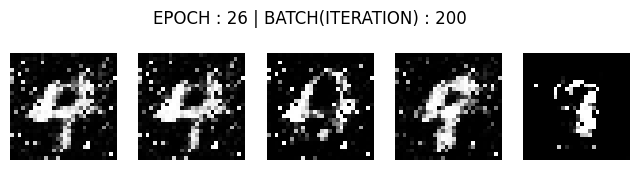

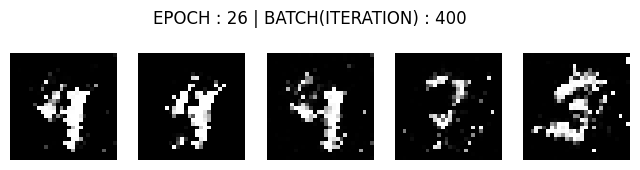

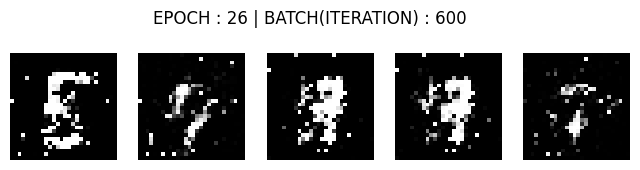

[Epoch: 26/100] [Batch: 657/657] [D loss: 0.517068] [G loss: 5.197915]


  0%|          | 0/657 [00:00<?, ?it/s]

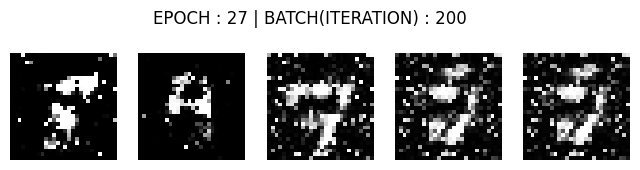

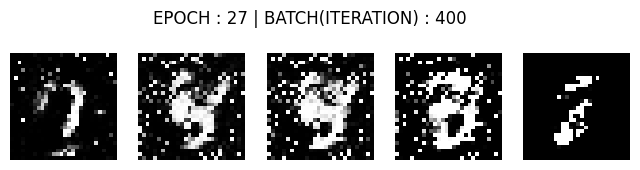

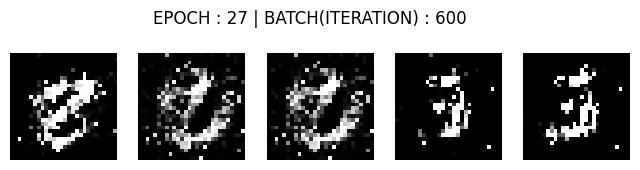

[Epoch: 27/100] [Batch: 657/657] [D loss: 0.082047] [G loss: 2.754943]


  0%|          | 0/657 [00:00<?, ?it/s]

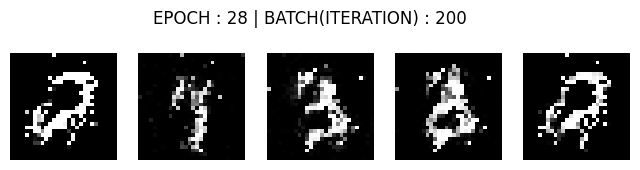

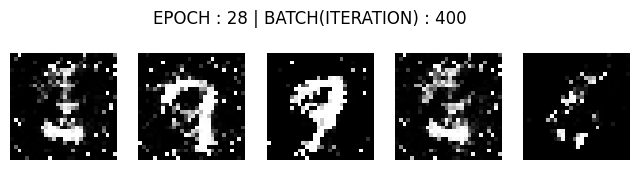

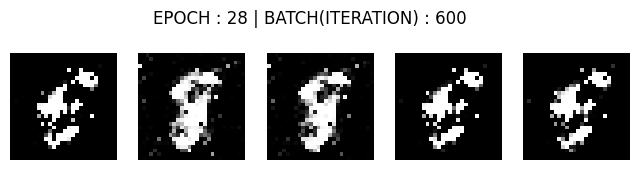

[Epoch: 28/100] [Batch: 657/657] [D loss: 0.222357] [G loss: 2.616768]


  0%|          | 0/657 [00:00<?, ?it/s]

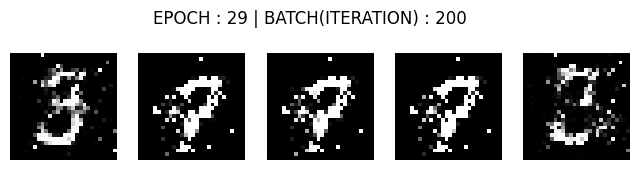

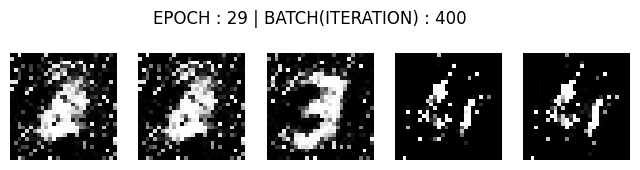

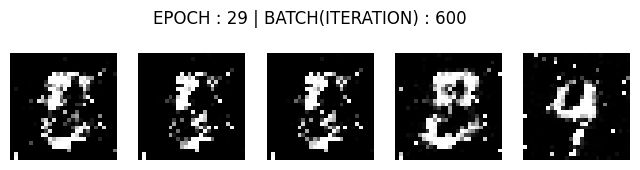

[Epoch: 29/100] [Batch: 657/657] [D loss: 0.399500] [G loss: 5.362935]


  0%|          | 0/657 [00:00<?, ?it/s]

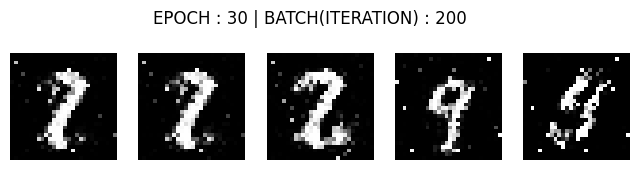

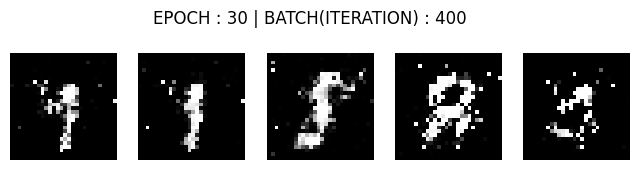

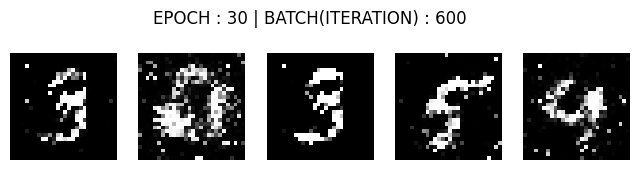

[Epoch: 30/100] [Batch: 657/657] [D loss: 0.379598] [G loss: 5.250449]


  0%|          | 0/657 [00:00<?, ?it/s]

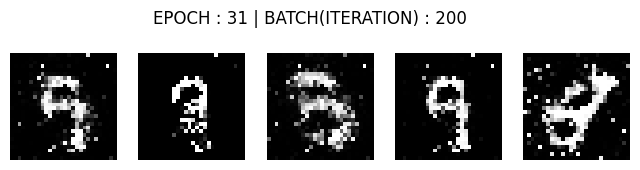

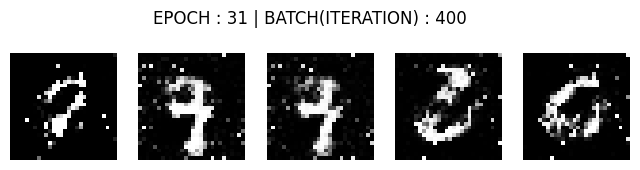

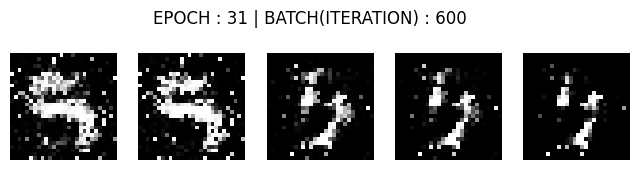

[Epoch: 31/100] [Batch: 657/657] [D loss: 0.117573] [G loss: 3.166649]


  0%|          | 0/657 [00:00<?, ?it/s]

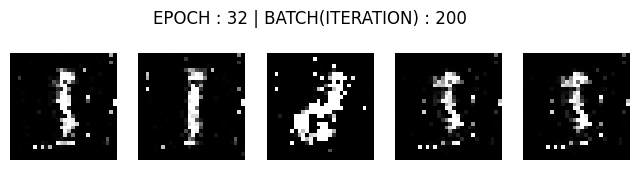

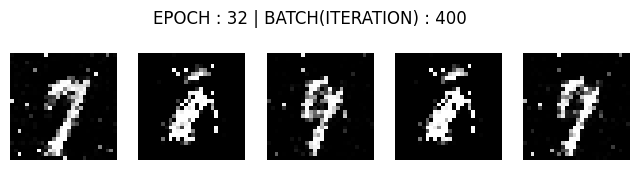

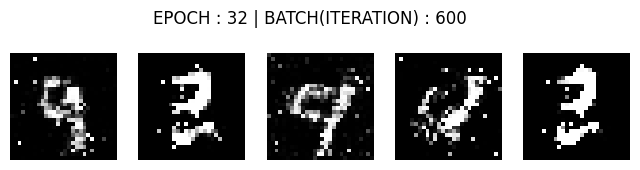

[Epoch: 32/100] [Batch: 657/657] [D loss: 0.125002] [G loss: 1.878494]


  0%|          | 0/657 [00:00<?, ?it/s]

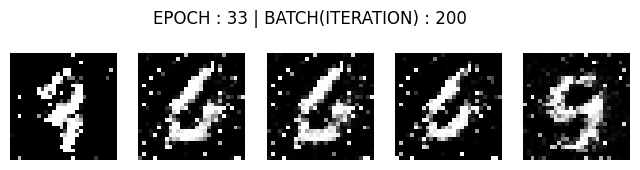

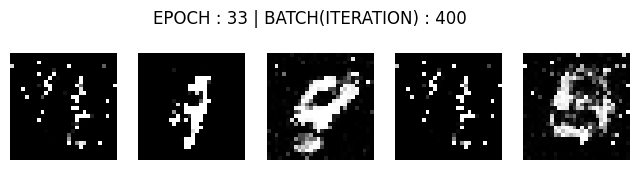

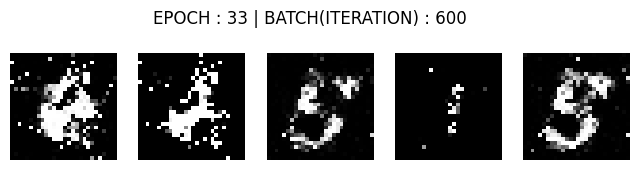

[Epoch: 33/100] [Batch: 657/657] [D loss: 0.312667] [G loss: 6.864123]


  0%|          | 0/657 [00:00<?, ?it/s]

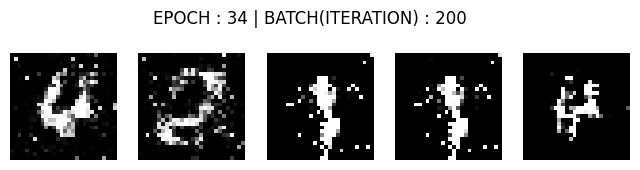

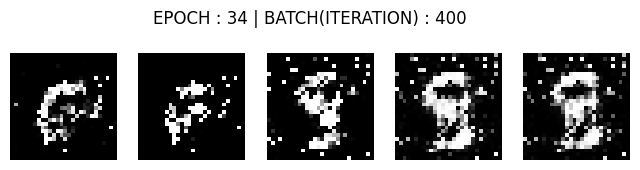

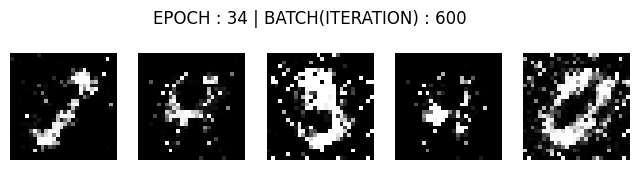

[Epoch: 34/100] [Batch: 657/657] [D loss: 0.170556] [G loss: 2.035763]


  0%|          | 0/657 [00:00<?, ?it/s]

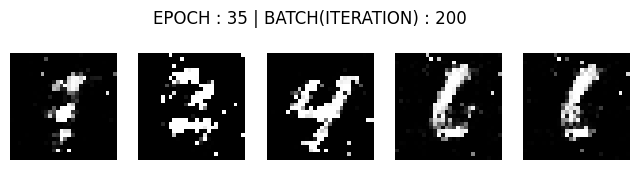

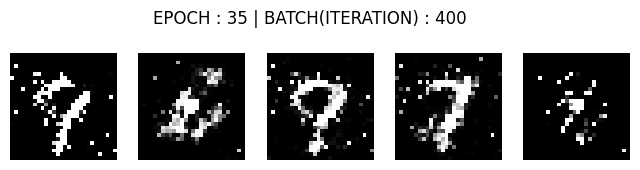

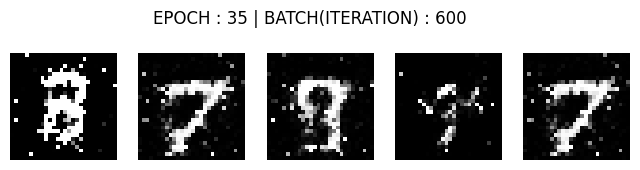

[Epoch: 35/100] [Batch: 657/657] [D loss: 0.141383] [G loss: 2.008755]


  0%|          | 0/657 [00:00<?, ?it/s]

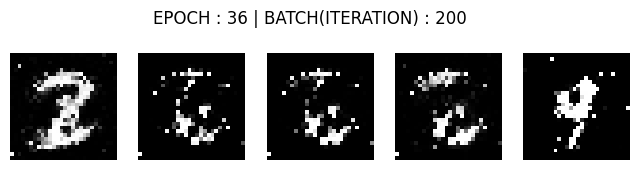

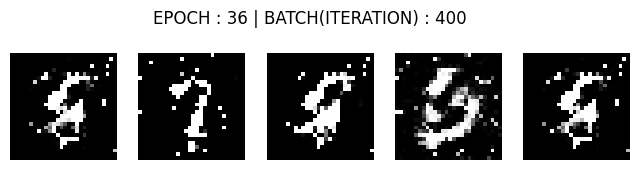

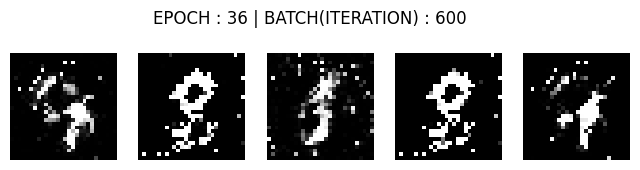

[Epoch: 36/100] [Batch: 657/657] [D loss: 0.051875] [G loss: 3.546722]


  0%|          | 0/657 [00:00<?, ?it/s]

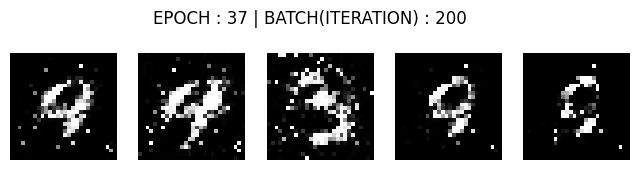

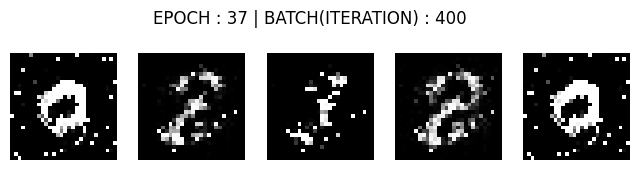

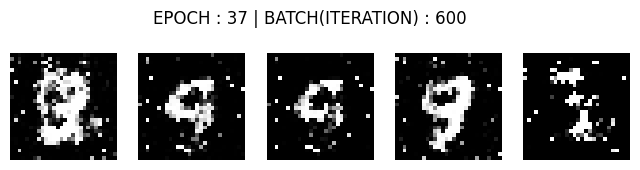

[Epoch: 37/100] [Batch: 657/657] [D loss: 0.063408] [G loss: 4.343849]


  0%|          | 0/657 [00:00<?, ?it/s]

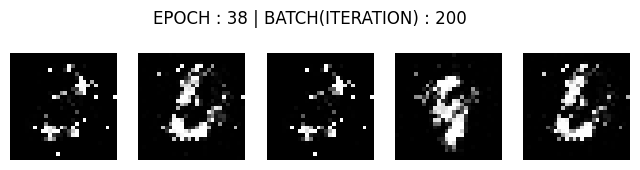

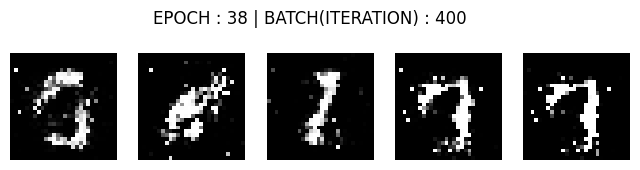

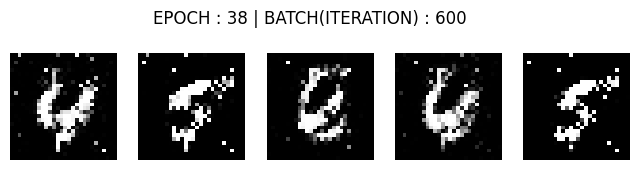

[Epoch: 38/100] [Batch: 657/657] [D loss: 0.141019] [G loss: 2.492499]


  0%|          | 0/657 [00:00<?, ?it/s]

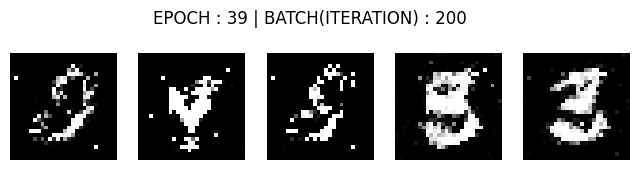

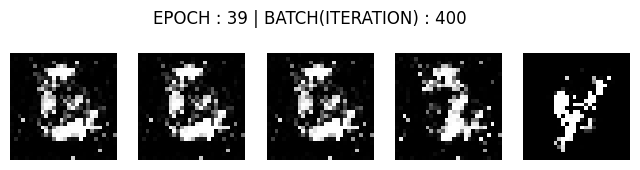

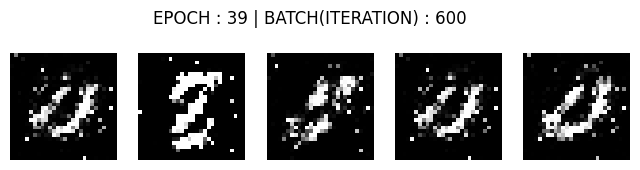

[Epoch: 39/100] [Batch: 657/657] [D loss: 0.129956] [G loss: 3.352630]


  0%|          | 0/657 [00:00<?, ?it/s]

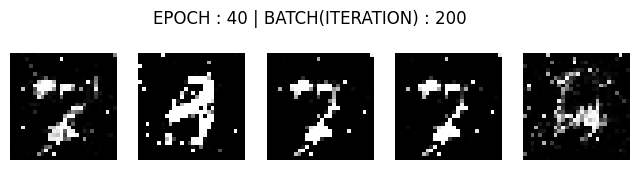

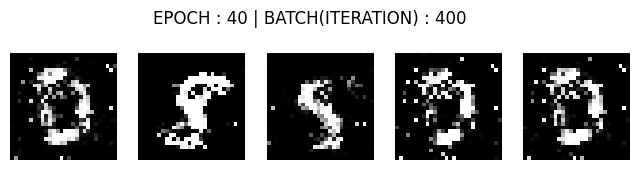

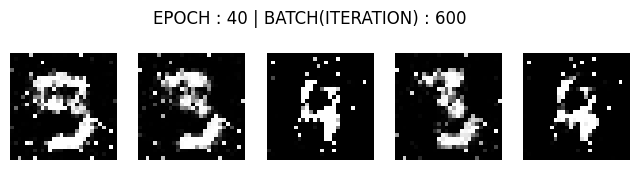

[Epoch: 40/100] [Batch: 657/657] [D loss: 0.174572] [G loss: 3.825665]


  0%|          | 0/657 [00:00<?, ?it/s]

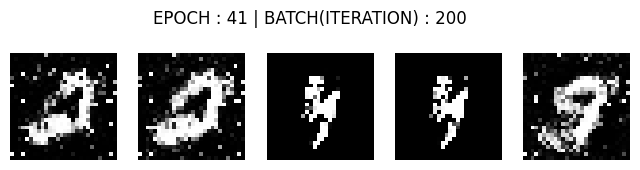

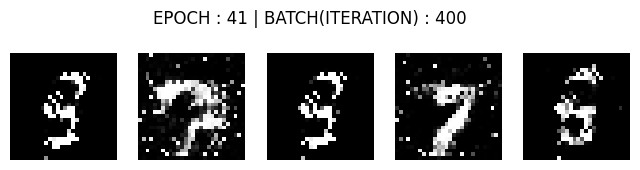

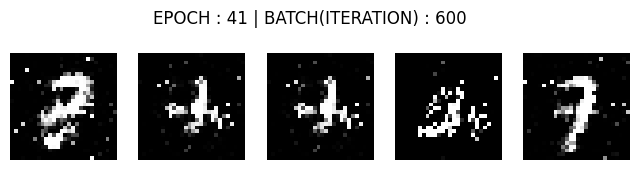

[Epoch: 41/100] [Batch: 657/657] [D loss: 0.017064] [G loss: 3.990573]


  0%|          | 0/657 [00:00<?, ?it/s]

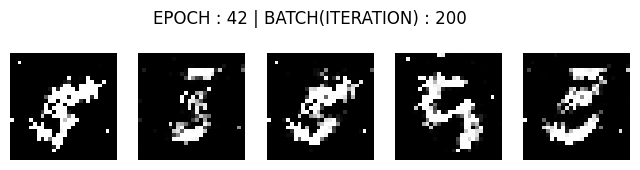

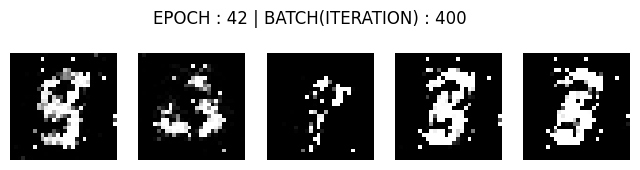

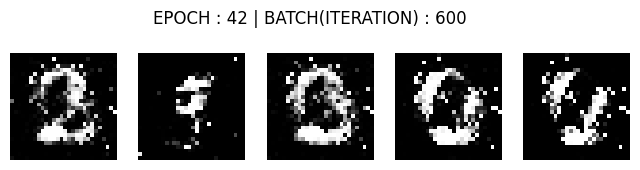

[Epoch: 42/100] [Batch: 657/657] [D loss: 0.110453] [G loss: 2.583480]


  0%|          | 0/657 [00:00<?, ?it/s]

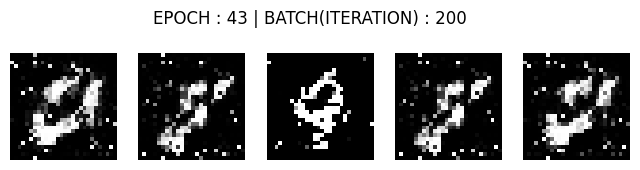

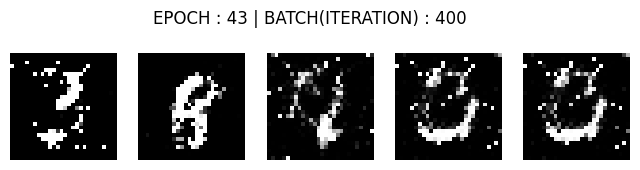

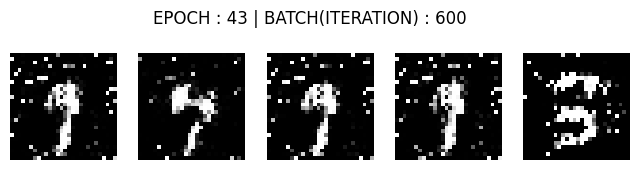

[Epoch: 43/100] [Batch: 657/657] [D loss: 0.123207] [G loss: 4.065563]


  0%|          | 0/657 [00:00<?, ?it/s]

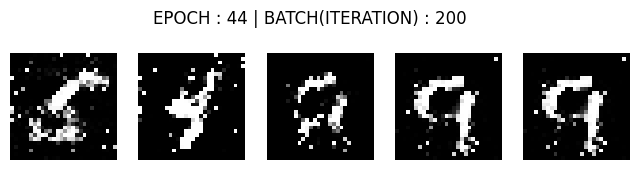

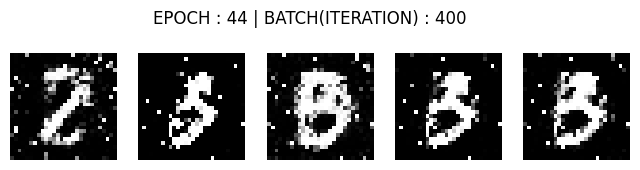

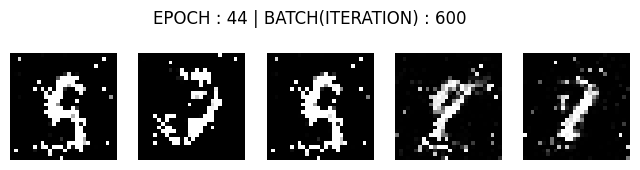

[Epoch: 44/100] [Batch: 657/657] [D loss: 0.070352] [G loss: 3.150752]


  0%|          | 0/657 [00:00<?, ?it/s]

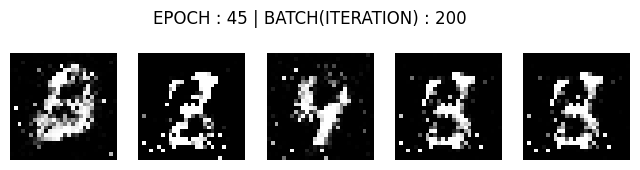

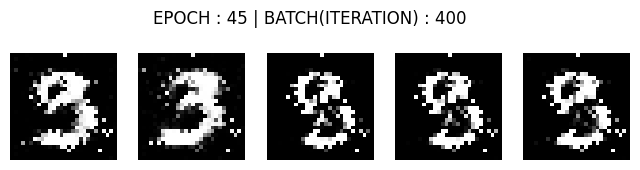

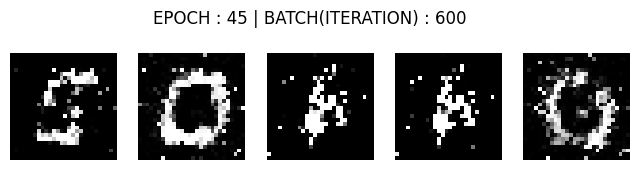

[Epoch: 45/100] [Batch: 657/657] [D loss: 0.038641] [G loss: 3.795975]


  0%|          | 0/657 [00:00<?, ?it/s]

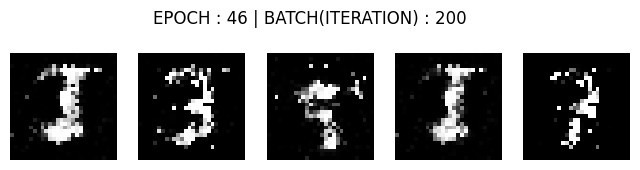

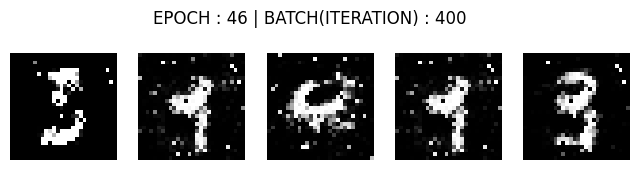

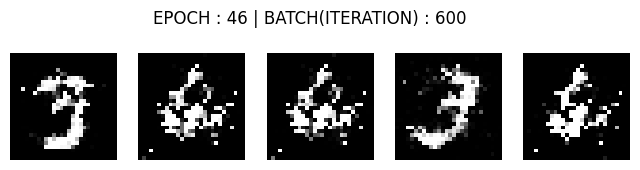

[Epoch: 46/100] [Batch: 657/657] [D loss: 0.335181] [G loss: 3.412909]


  0%|          | 0/657 [00:00<?, ?it/s]

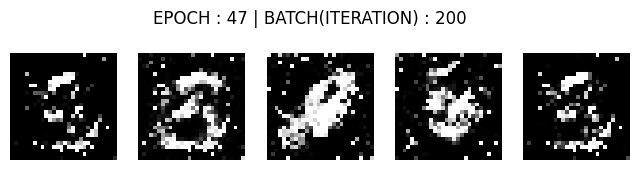

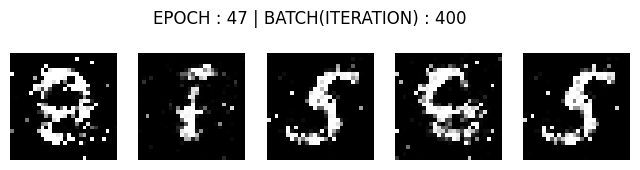

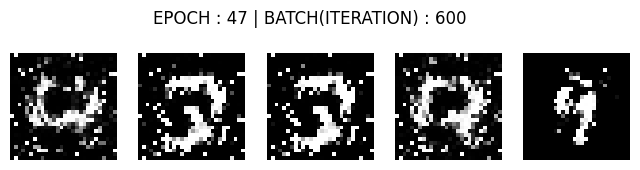

[Epoch: 47/100] [Batch: 657/657] [D loss: 0.280758] [G loss: 3.681590]


  0%|          | 0/657 [00:00<?, ?it/s]

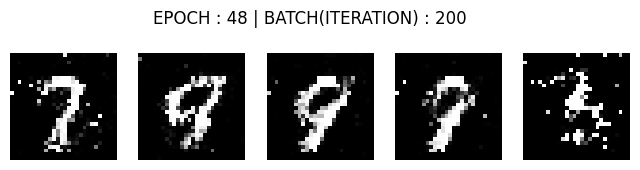

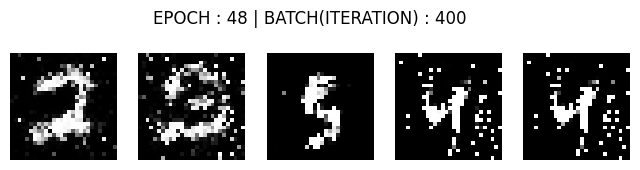

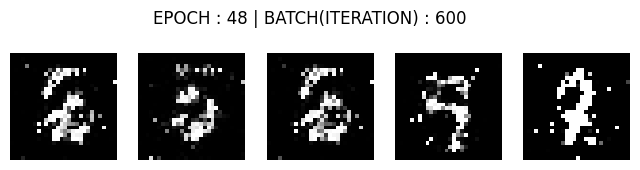

[Epoch: 48/100] [Batch: 657/657] [D loss: 0.047585] [G loss: 2.560658]


  0%|          | 0/657 [00:00<?, ?it/s]

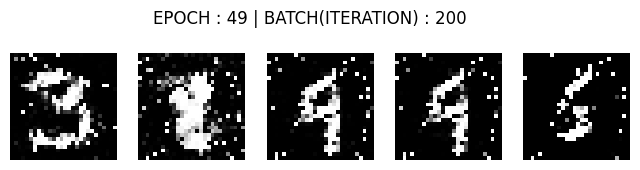

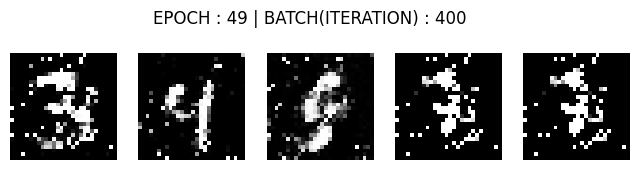

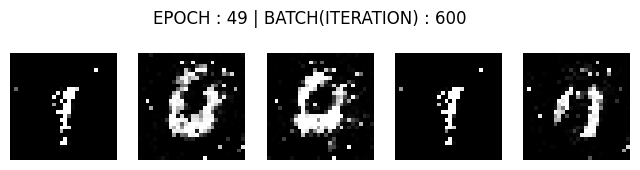

[Epoch: 49/100] [Batch: 657/657] [D loss: 0.322044] [G loss: 5.196513]


  0%|          | 0/657 [00:00<?, ?it/s]

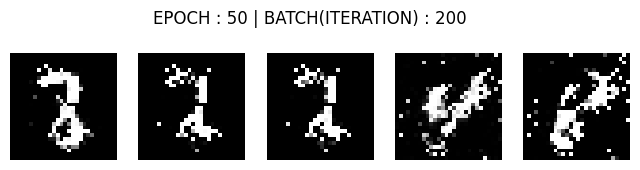

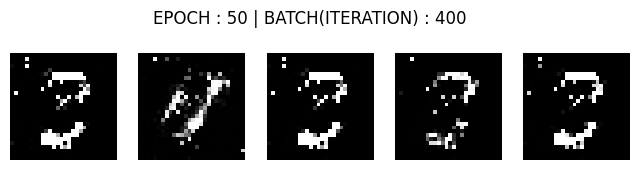

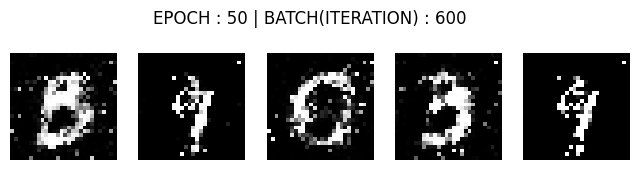

[Epoch: 50/100] [Batch: 657/657] [D loss: 0.152156] [G loss: 3.204448]


  0%|          | 0/657 [00:00<?, ?it/s]

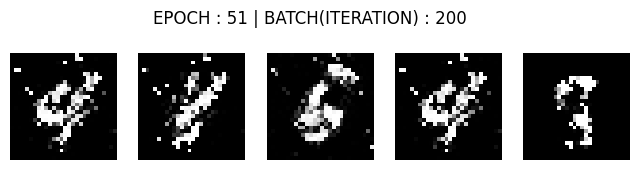

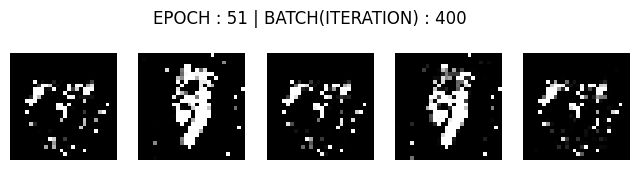

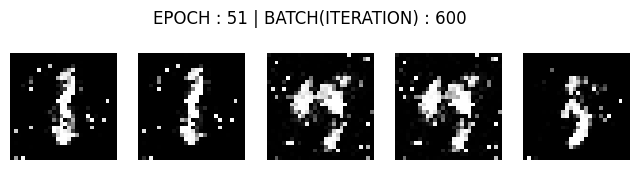

[Epoch: 51/100] [Batch: 657/657] [D loss: 0.100826] [G loss: 2.598382]


  0%|          | 0/657 [00:00<?, ?it/s]

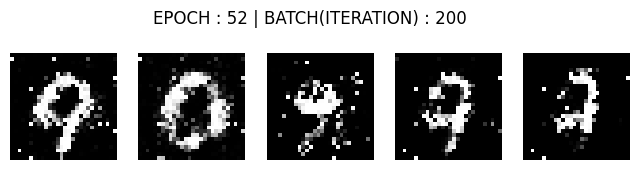

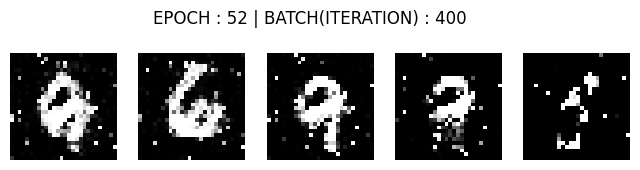

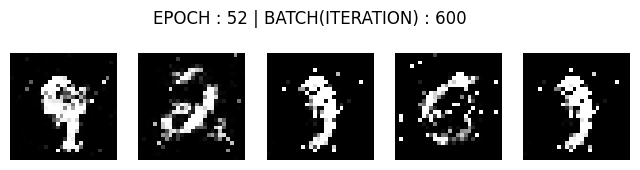

[Epoch: 52/100] [Batch: 657/657] [D loss: 0.529448] [G loss: 5.709983]


  0%|          | 0/657 [00:00<?, ?it/s]

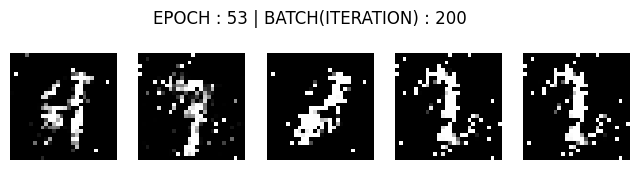

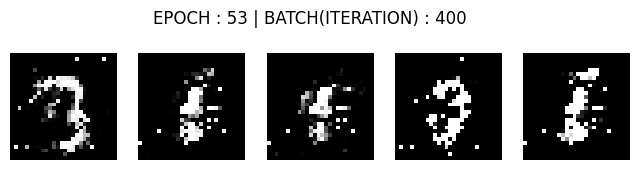

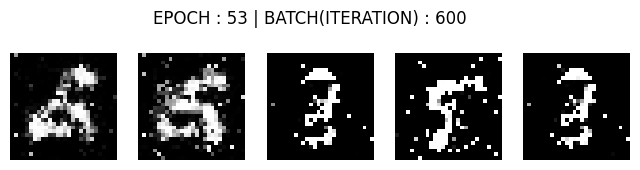

[Epoch: 53/100] [Batch: 657/657] [D loss: 0.326370] [G loss: 1.594483]


  0%|          | 0/657 [00:00<?, ?it/s]

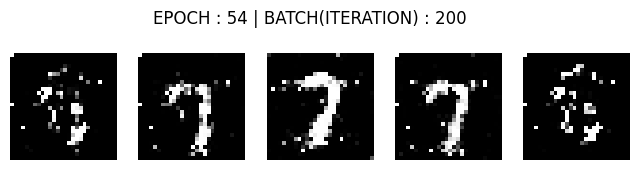

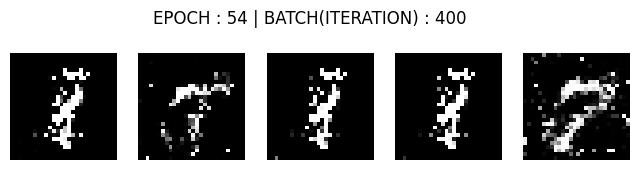

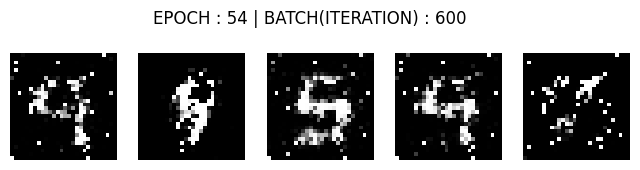

[Epoch: 54/100] [Batch: 657/657] [D loss: 0.032753] [G loss: 4.332073]


  0%|          | 0/657 [00:00<?, ?it/s]

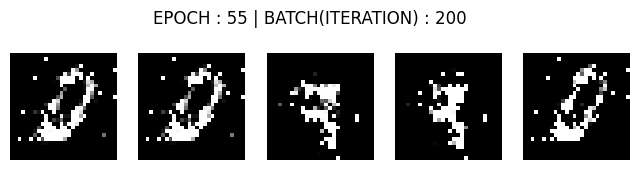

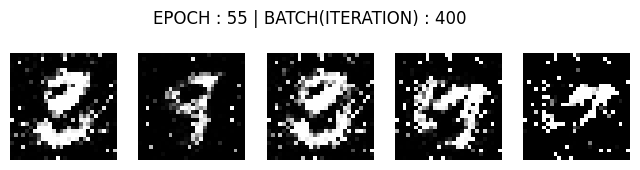

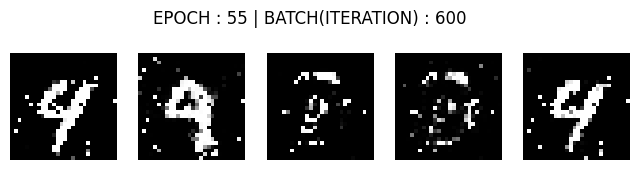

[Epoch: 55/100] [Batch: 657/657] [D loss: 0.043434] [G loss: 5.043252]


  0%|          | 0/657 [00:00<?, ?it/s]

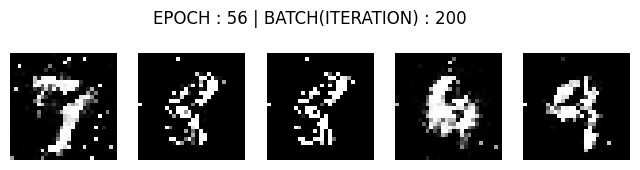

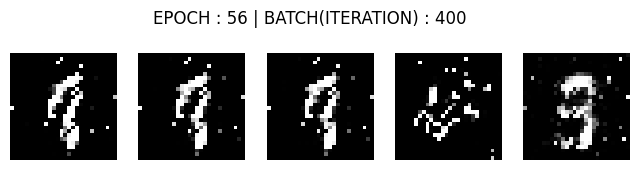

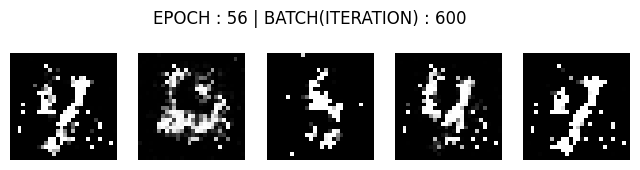

[Epoch: 56/100] [Batch: 657/657] [D loss: 0.072205] [G loss: 2.381176]


  0%|          | 0/657 [00:00<?, ?it/s]

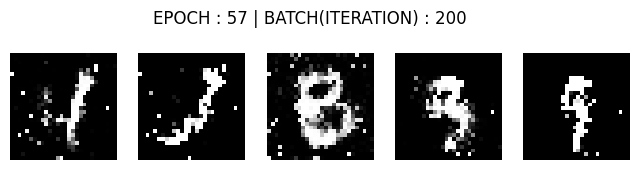

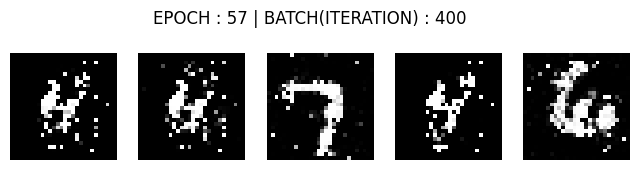

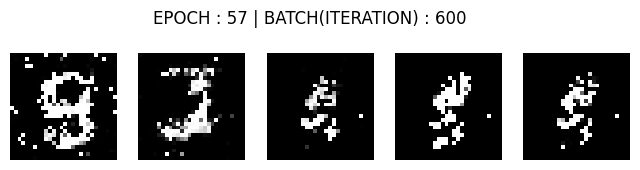

[Epoch: 57/100] [Batch: 657/657] [D loss: 0.166390] [G loss: 2.308499]


  0%|          | 0/657 [00:00<?, ?it/s]

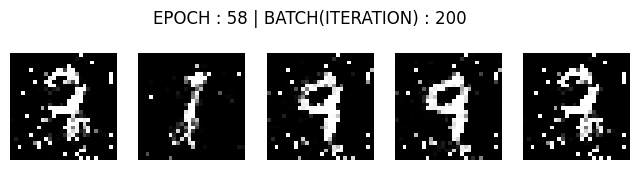

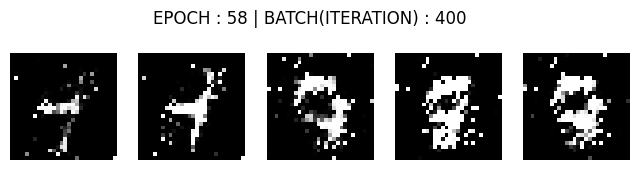

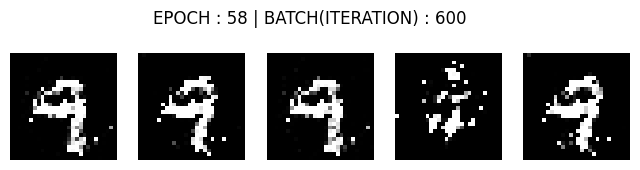

[Epoch: 58/100] [Batch: 657/657] [D loss: 0.122117] [G loss: 3.425472]


  0%|          | 0/657 [00:00<?, ?it/s]

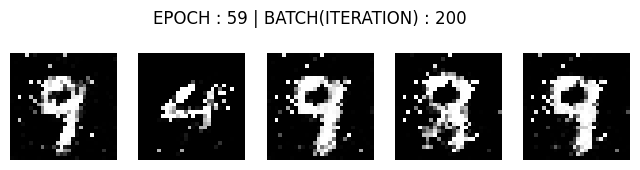

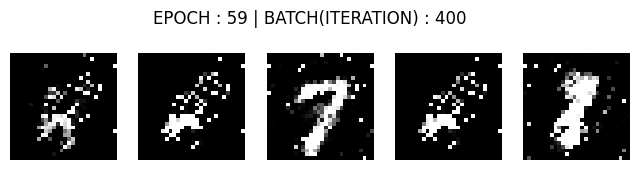

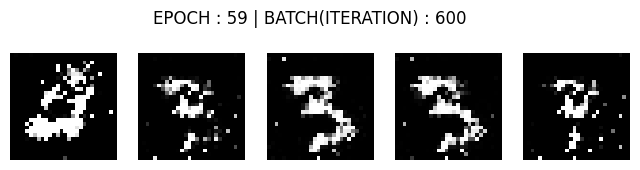

[Epoch: 59/100] [Batch: 657/657] [D loss: 0.202560] [G loss: 2.850158]


  0%|          | 0/657 [00:00<?, ?it/s]

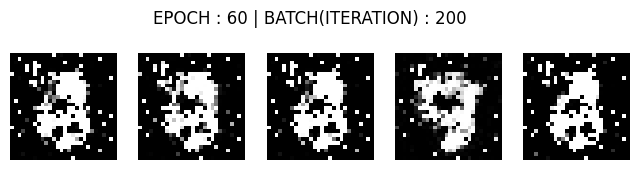

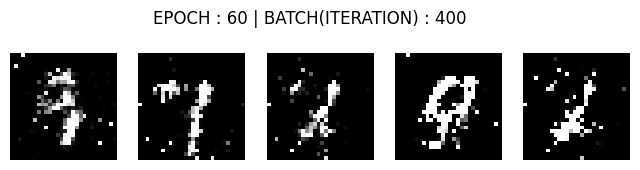

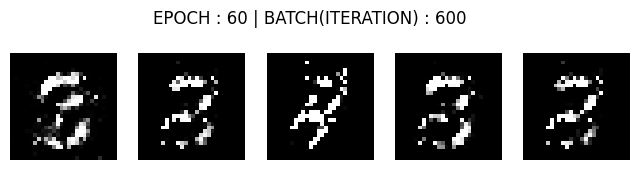

[Epoch: 60/100] [Batch: 657/657] [D loss: 0.118475] [G loss: 2.288240]


  0%|          | 0/657 [00:00<?, ?it/s]

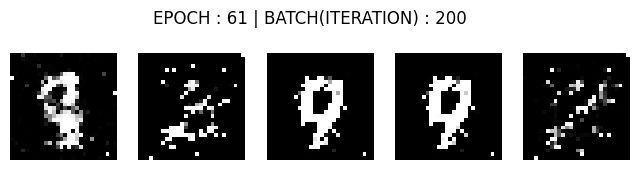

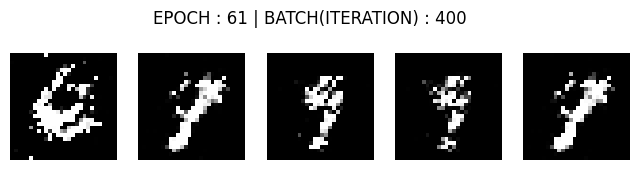

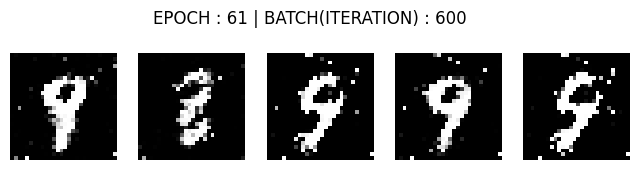

[Epoch: 61/100] [Batch: 657/657] [D loss: 0.210684] [G loss: 5.953991]


  0%|          | 0/657 [00:00<?, ?it/s]

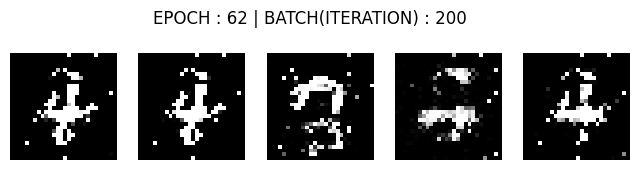

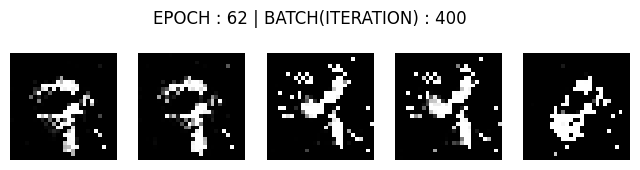

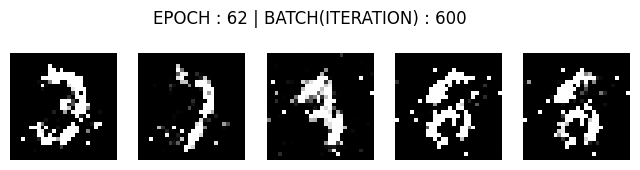

[Epoch: 62/100] [Batch: 657/657] [D loss: 0.061320] [G loss: 6.290292]


  0%|          | 0/657 [00:00<?, ?it/s]

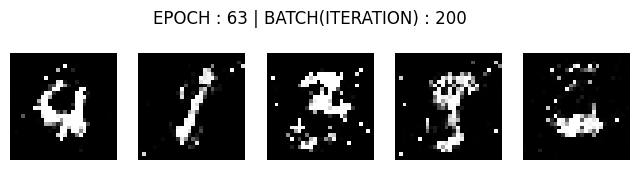

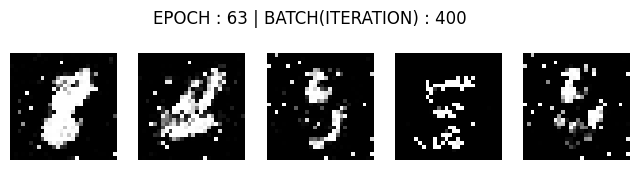

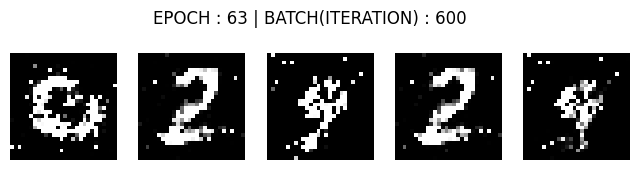

[Epoch: 63/100] [Batch: 657/657] [D loss: 0.028651] [G loss: 3.692951]


  0%|          | 0/657 [00:00<?, ?it/s]

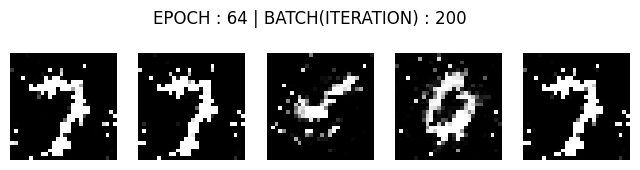

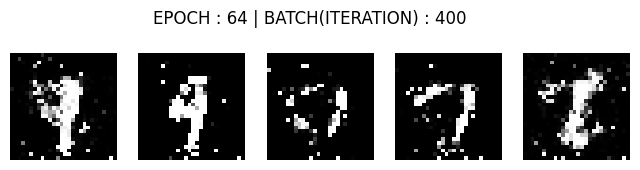

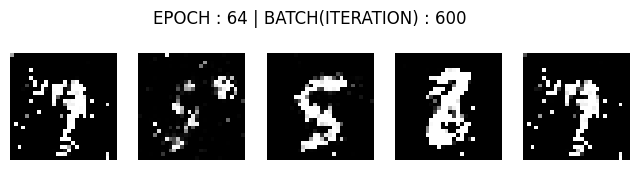

[Epoch: 64/100] [Batch: 657/657] [D loss: 0.090542] [G loss: 2.162515]


  0%|          | 0/657 [00:00<?, ?it/s]

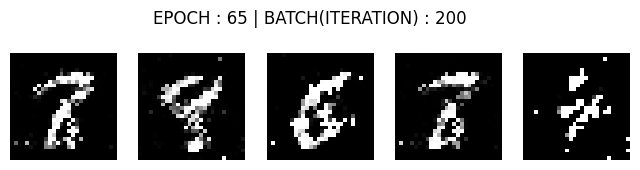

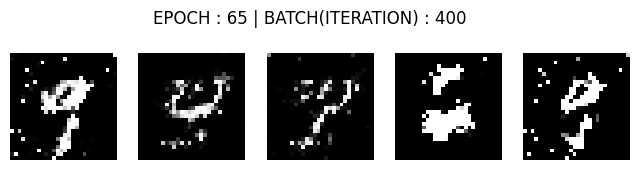

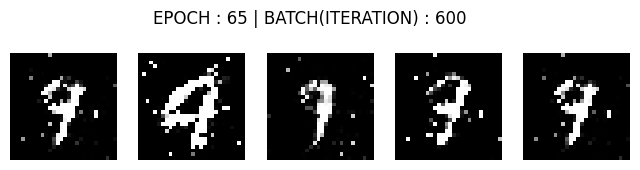

[Epoch: 65/100] [Batch: 657/657] [D loss: 0.091786] [G loss: 4.486829]


  0%|          | 0/657 [00:00<?, ?it/s]

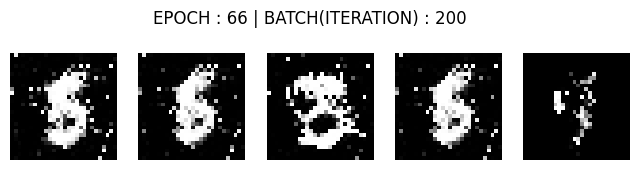

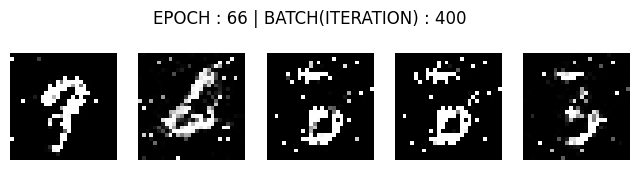

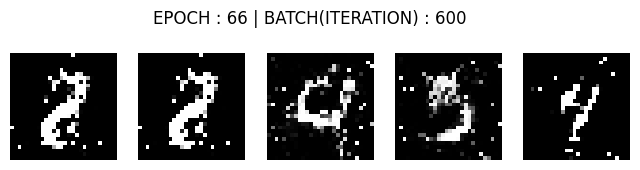

[Epoch: 66/100] [Batch: 657/657] [D loss: 0.222962] [G loss: 3.679355]


  0%|          | 0/657 [00:00<?, ?it/s]

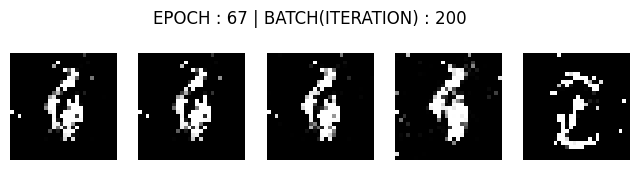

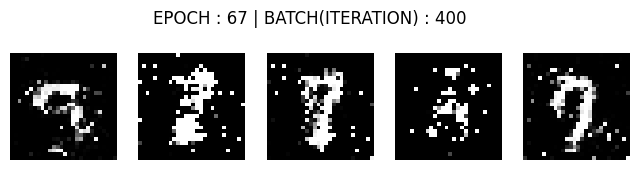

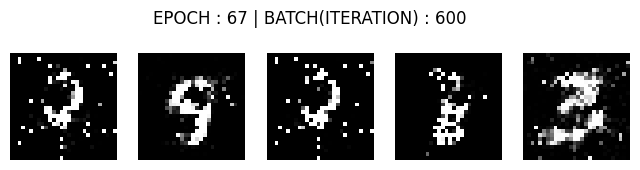

[Epoch: 67/100] [Batch: 657/657] [D loss: 0.108278] [G loss: 4.797827]


  0%|          | 0/657 [00:00<?, ?it/s]

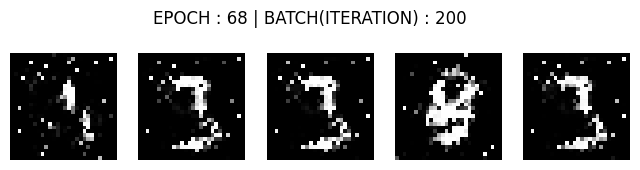

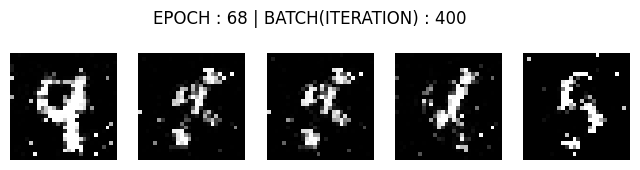

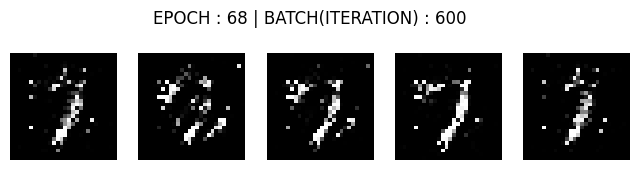

[Epoch: 68/100] [Batch: 657/657] [D loss: 0.051195] [G loss: 2.889216]


  0%|          | 0/657 [00:00<?, ?it/s]

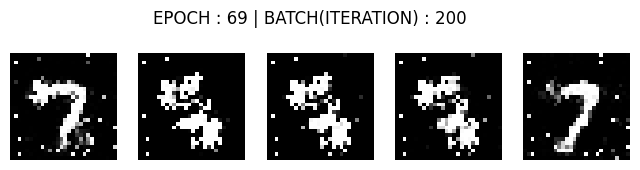

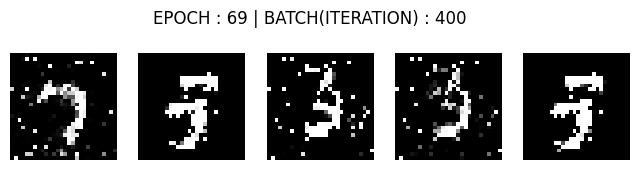

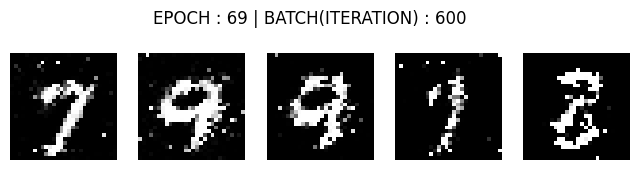

[Epoch: 69/100] [Batch: 657/657] [D loss: 0.048602] [G loss: 3.583344]


  0%|          | 0/657 [00:00<?, ?it/s]

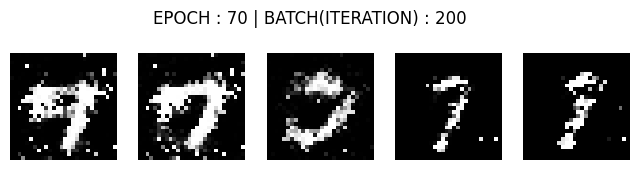

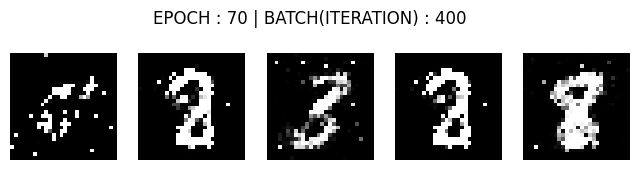

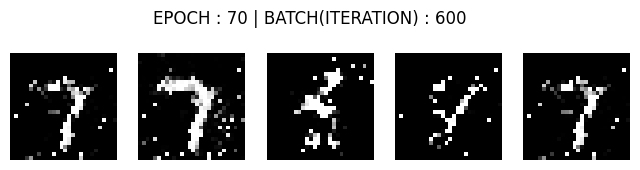

[Epoch: 70/100] [Batch: 657/657] [D loss: 0.096447] [G loss: 2.518469]


  0%|          | 0/657 [00:00<?, ?it/s]

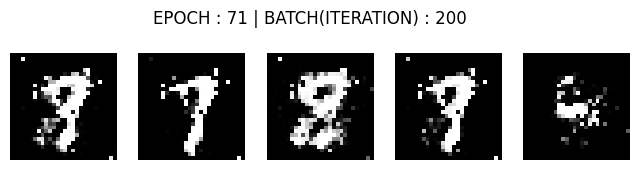

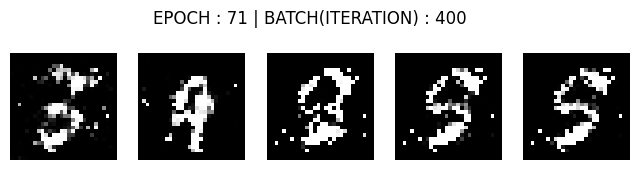

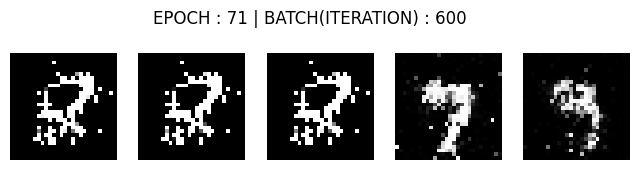

[Epoch: 71/100] [Batch: 657/657] [D loss: 0.043966] [G loss: 3.479610]


  0%|          | 0/657 [00:00<?, ?it/s]

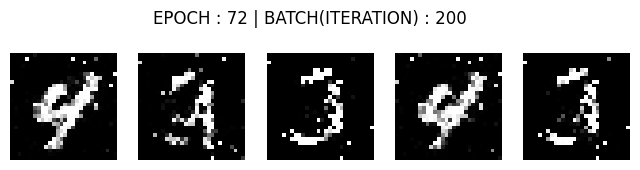

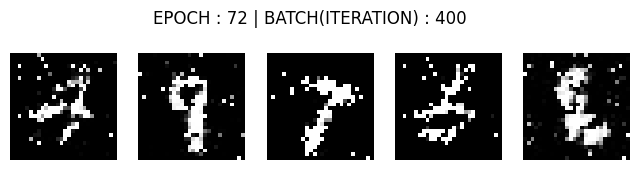

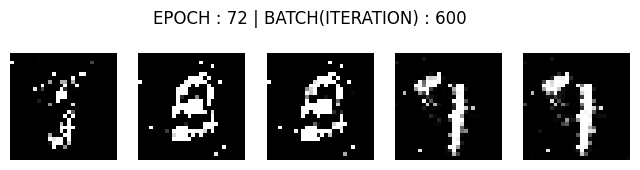

[Epoch: 72/100] [Batch: 657/657] [D loss: 0.091245] [G loss: 3.726172]


  0%|          | 0/657 [00:00<?, ?it/s]

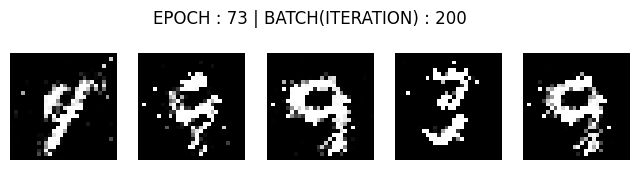

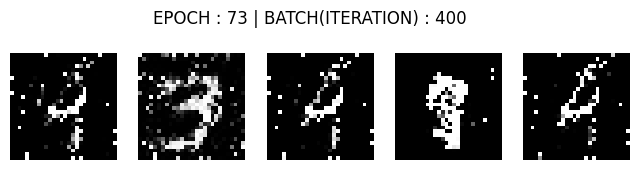

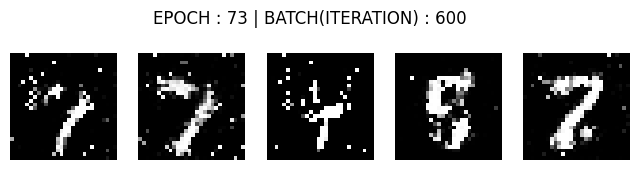

[Epoch: 73/100] [Batch: 657/657] [D loss: 0.250251] [G loss: 1.934932]


  0%|          | 0/657 [00:00<?, ?it/s]

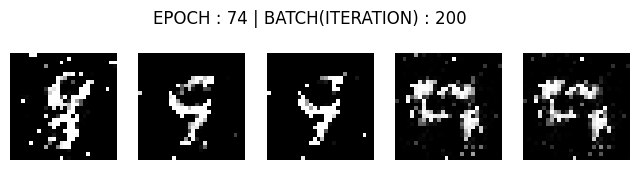

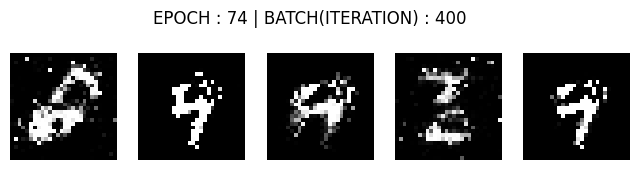

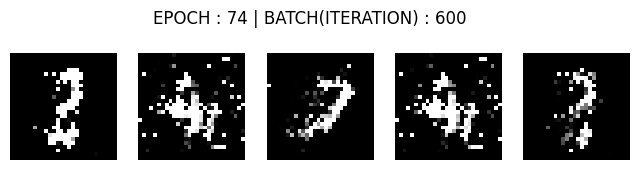

[Epoch: 74/100] [Batch: 657/657] [D loss: 0.270114] [G loss: 6.734588]


  0%|          | 0/657 [00:00<?, ?it/s]

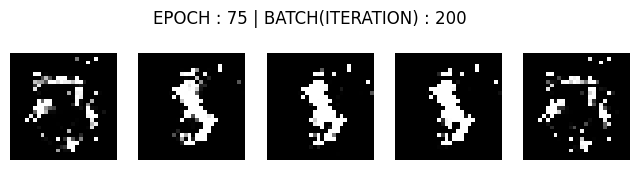

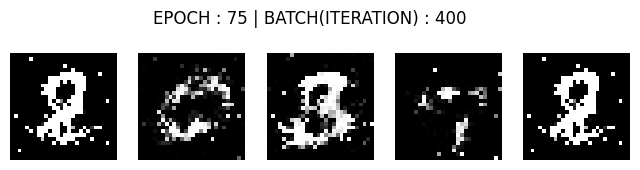

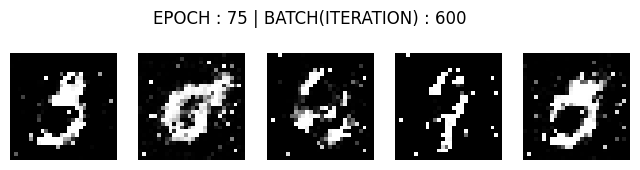

[Epoch: 75/100] [Batch: 657/657] [D loss: 0.026237] [G loss: 3.900078]


  0%|          | 0/657 [00:00<?, ?it/s]

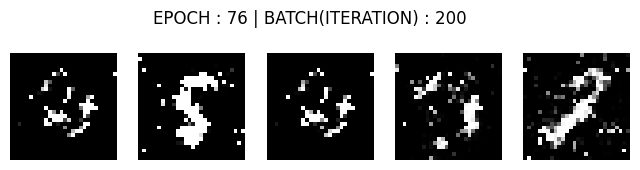

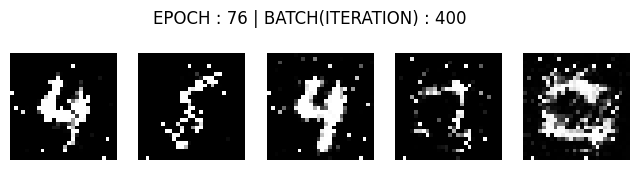

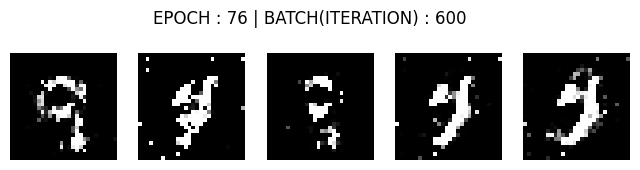

[Epoch: 76/100] [Batch: 657/657] [D loss: 0.015884] [G loss: 4.312235]


  0%|          | 0/657 [00:00<?, ?it/s]

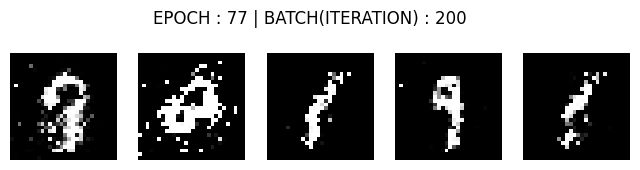

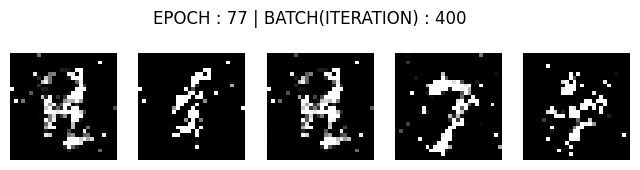

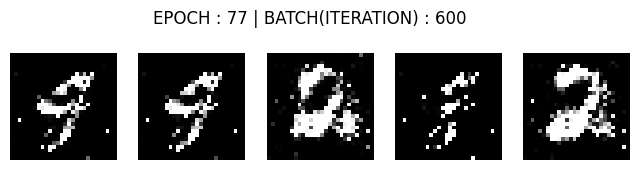

[Epoch: 77/100] [Batch: 657/657] [D loss: 0.123331] [G loss: 3.767488]


  0%|          | 0/657 [00:00<?, ?it/s]

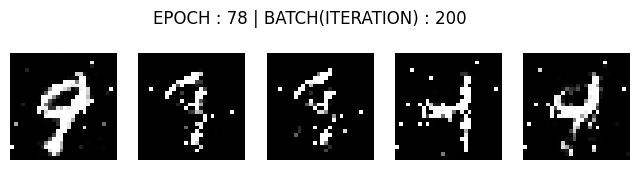

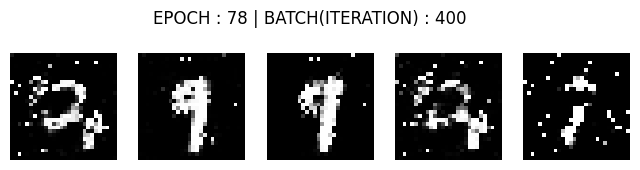

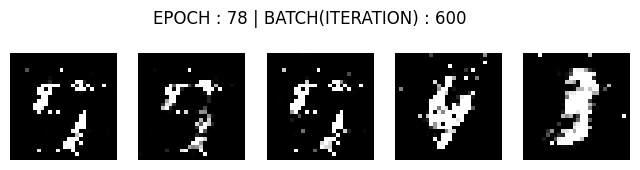

[Epoch: 78/100] [Batch: 657/657] [D loss: 0.340940] [G loss: 5.286707]


  0%|          | 0/657 [00:00<?, ?it/s]

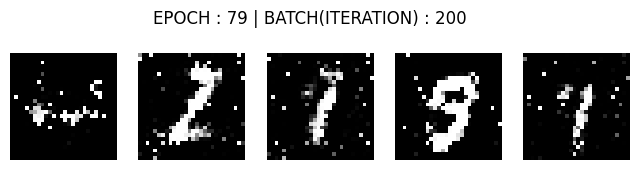

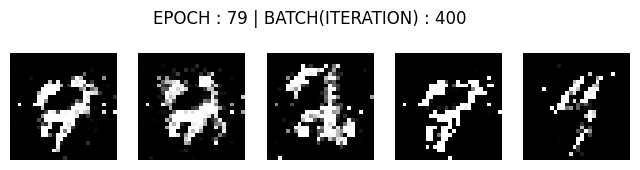

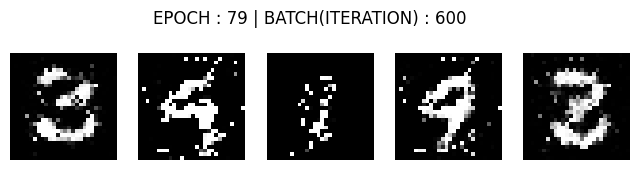

[Epoch: 79/100] [Batch: 657/657] [D loss: 0.108549] [G loss: 2.736095]


  0%|          | 0/657 [00:00<?, ?it/s]

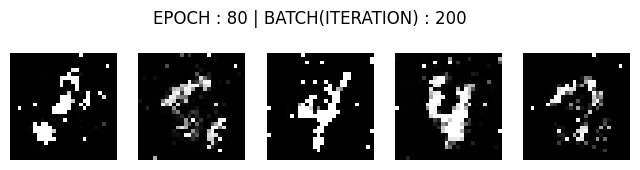

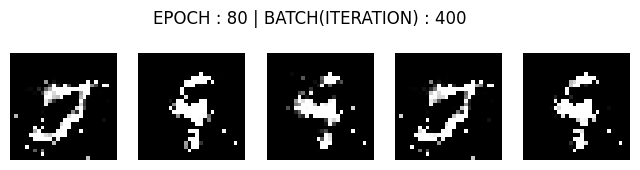

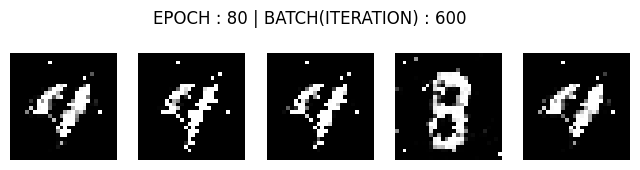

[Epoch: 80/100] [Batch: 657/657] [D loss: 0.045127] [G loss: 3.625760]


  0%|          | 0/657 [00:00<?, ?it/s]

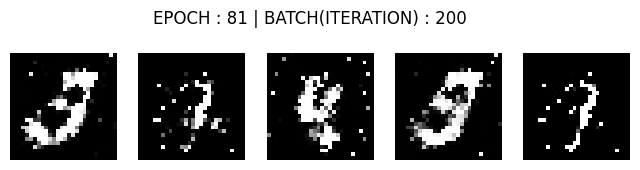

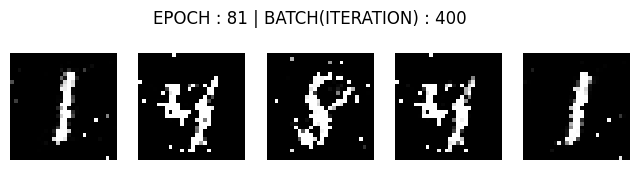

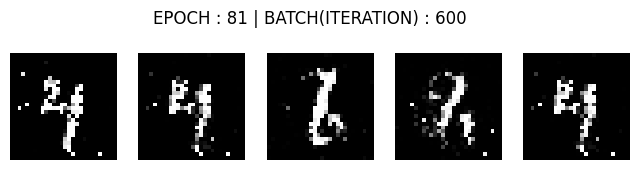

[Epoch: 81/100] [Batch: 657/657] [D loss: 0.115032] [G loss: 1.722139]


  0%|          | 0/657 [00:00<?, ?it/s]

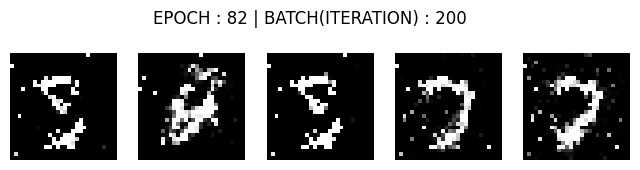

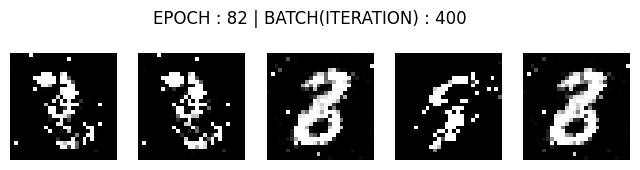

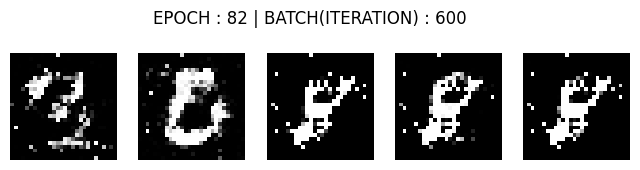

[Epoch: 82/100] [Batch: 657/657] [D loss: 0.130411] [G loss: 2.927761]


  0%|          | 0/657 [00:00<?, ?it/s]

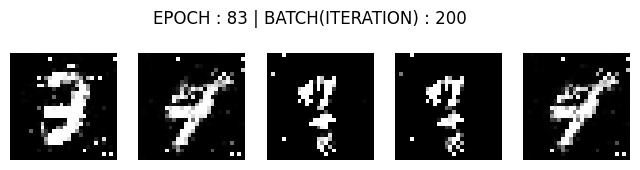

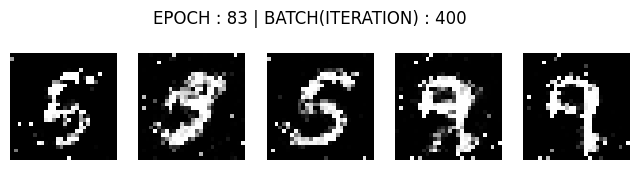

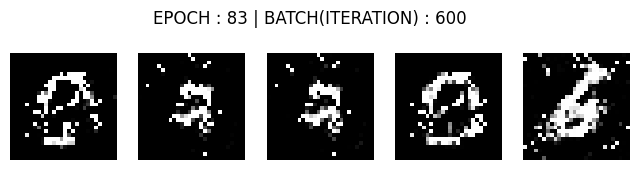

[Epoch: 83/100] [Batch: 657/657] [D loss: 0.393608] [G loss: 4.724016]


  0%|          | 0/657 [00:00<?, ?it/s]

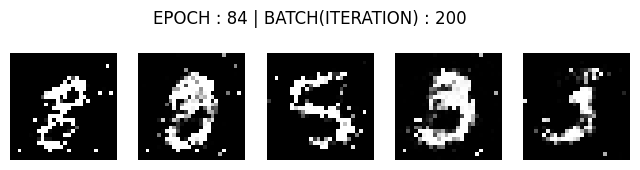

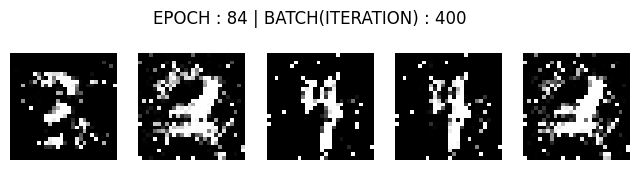

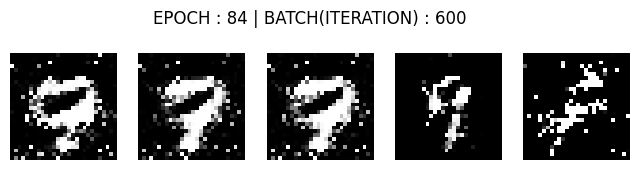

[Epoch: 84/100] [Batch: 657/657] [D loss: 0.282228] [G loss: 4.238174]


  0%|          | 0/657 [00:00<?, ?it/s]

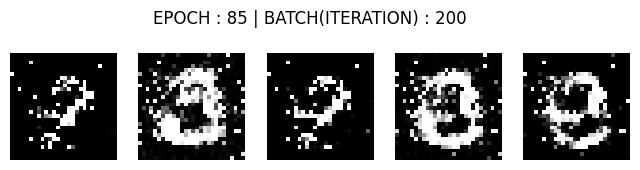

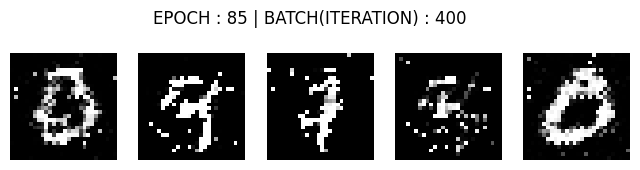

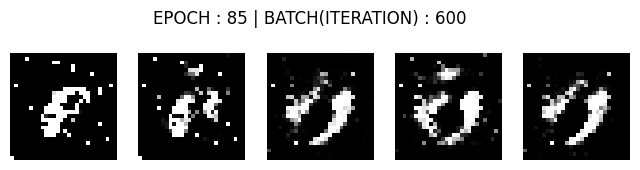

[Epoch: 85/100] [Batch: 657/657] [D loss: 0.095672] [G loss: 3.414887]


  0%|          | 0/657 [00:00<?, ?it/s]

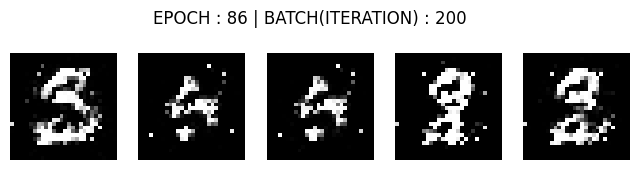

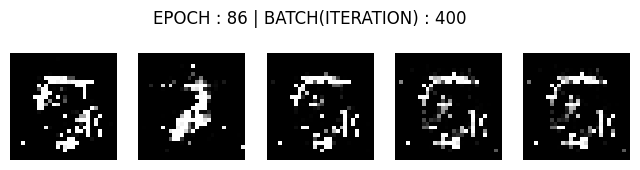

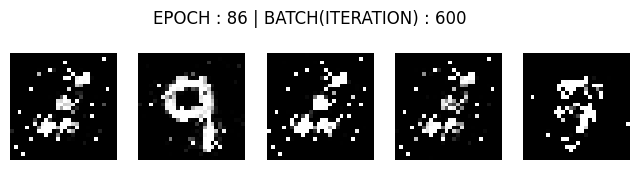

[Epoch: 86/100] [Batch: 657/657] [D loss: 0.328990] [G loss: 2.304044]


  0%|          | 0/657 [00:00<?, ?it/s]

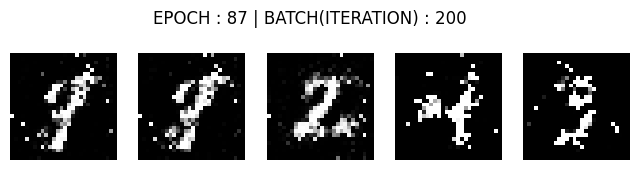

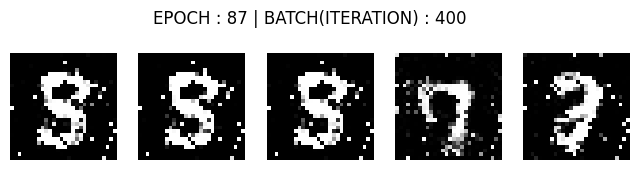

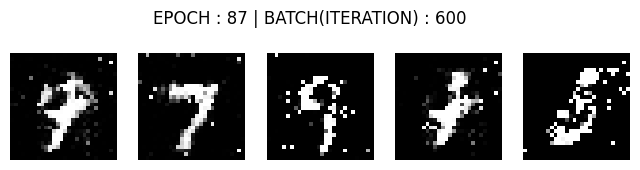

[Epoch: 87/100] [Batch: 657/657] [D loss: 0.055290] [G loss: 3.000658]


  0%|          | 0/657 [00:00<?, ?it/s]

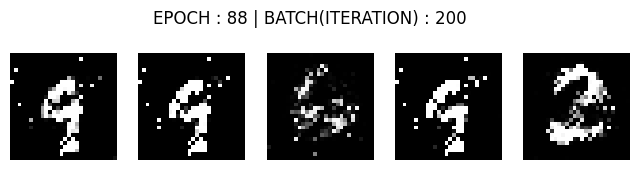

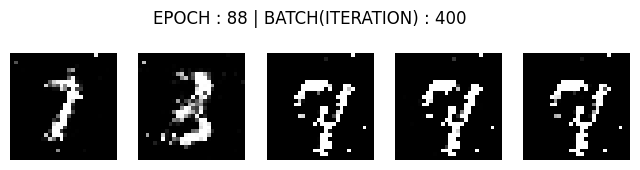

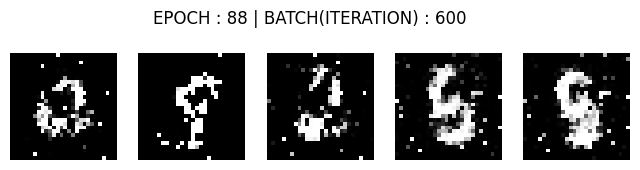

[Epoch: 88/100] [Batch: 657/657] [D loss: 0.011478] [G loss: 4.104691]


  0%|          | 0/657 [00:00<?, ?it/s]

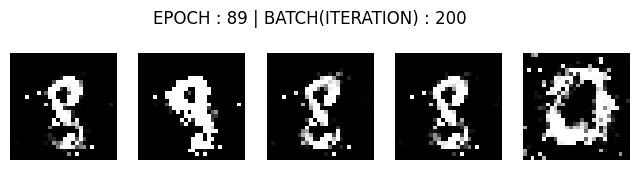

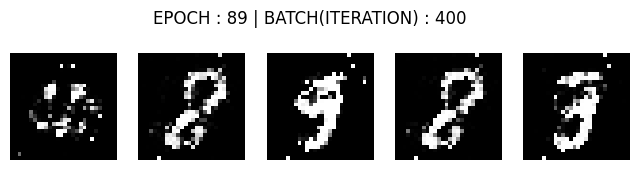

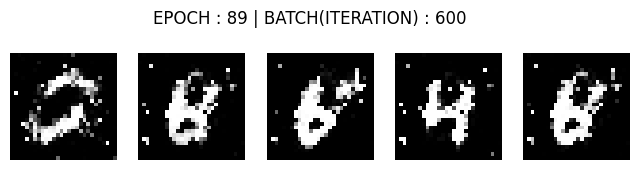

[Epoch: 89/100] [Batch: 657/657] [D loss: 0.026883] [G loss: 4.062377]


  0%|          | 0/657 [00:00<?, ?it/s]

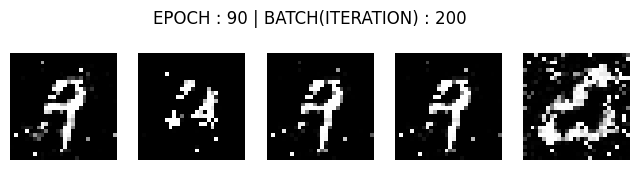

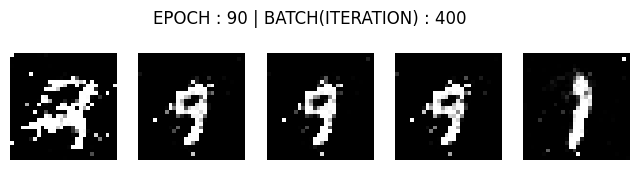

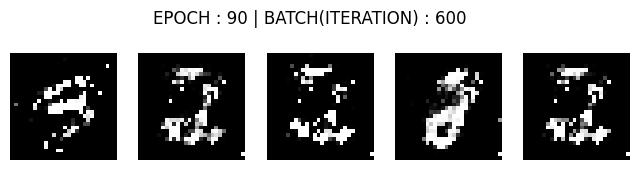

[Epoch: 90/100] [Batch: 657/657] [D loss: 0.043463] [G loss: 2.891015]


  0%|          | 0/657 [00:00<?, ?it/s]

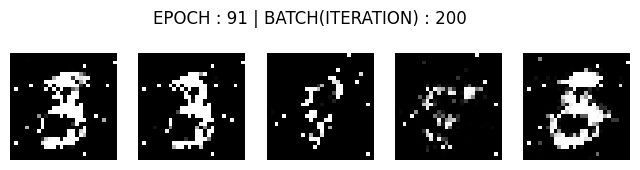

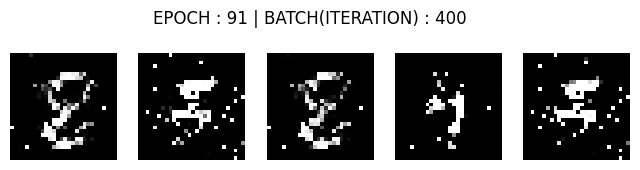

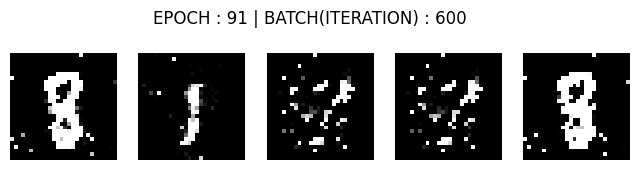

[Epoch: 91/100] [Batch: 657/657] [D loss: 0.169819] [G loss: 3.053479]


  0%|          | 0/657 [00:00<?, ?it/s]

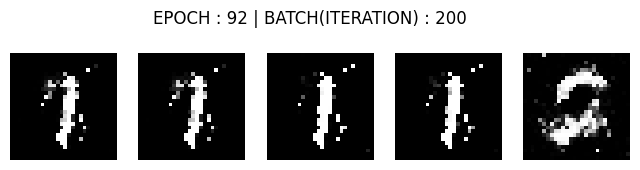

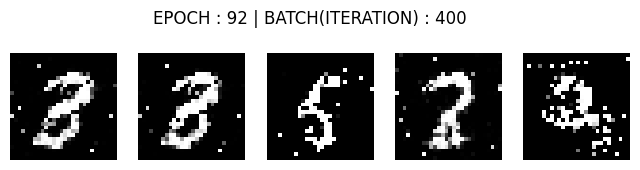

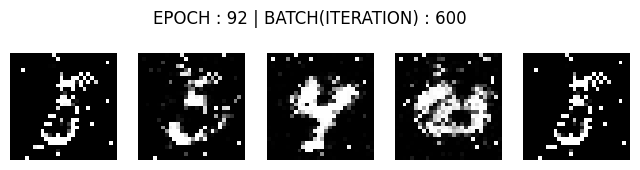

[Epoch: 92/100] [Batch: 657/657] [D loss: 0.516617] [G loss: 2.613019]


  0%|          | 0/657 [00:00<?, ?it/s]

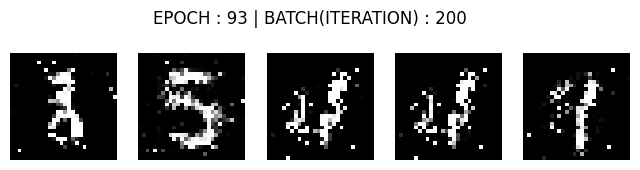

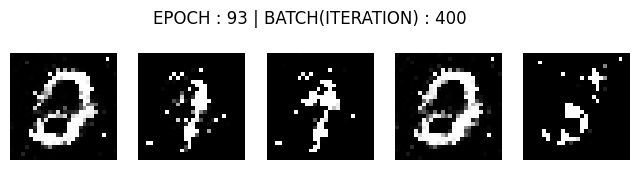

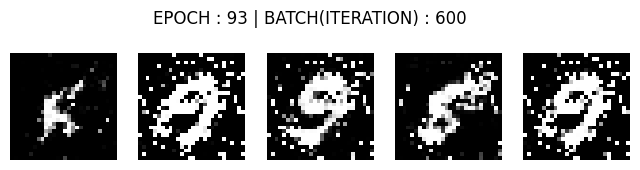

[Epoch: 93/100] [Batch: 657/657] [D loss: 0.116927] [G loss: 2.825658]


  0%|          | 0/657 [00:00<?, ?it/s]

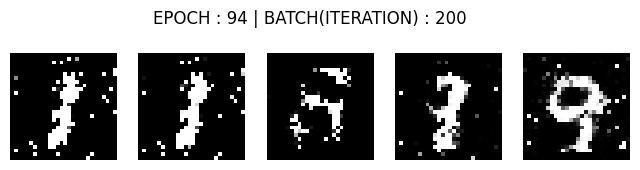

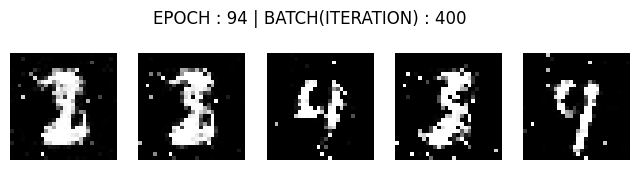

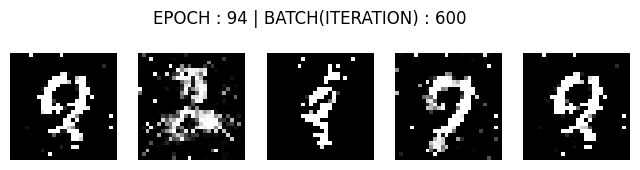

[Epoch: 94/100] [Batch: 657/657] [D loss: 0.176970] [G loss: 2.664050]


  0%|          | 0/657 [00:00<?, ?it/s]

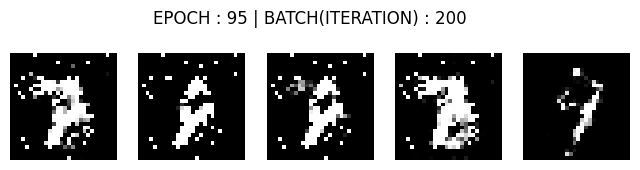

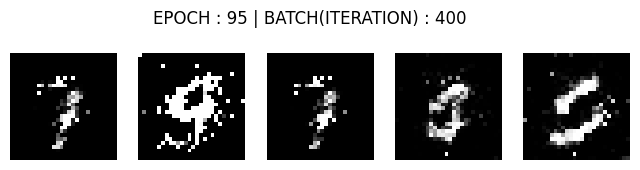

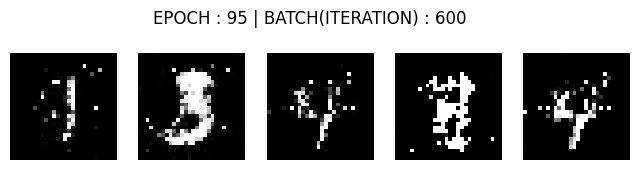

[Epoch: 95/100] [Batch: 657/657] [D loss: 0.031948] [G loss: 3.482225]


  0%|          | 0/657 [00:00<?, ?it/s]

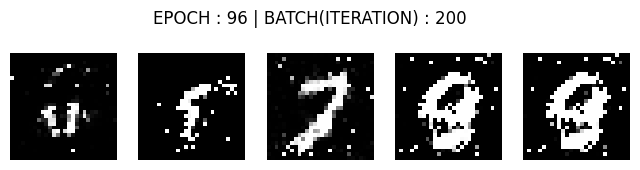

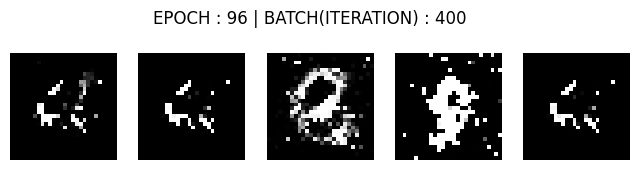

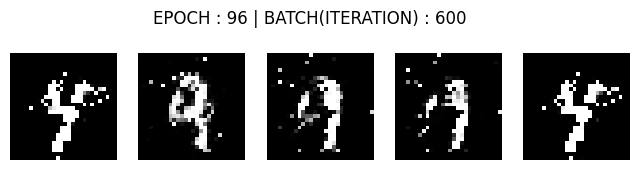

[Epoch: 96/100] [Batch: 657/657] [D loss: 0.075399] [G loss: 4.009557]


  0%|          | 0/657 [00:00<?, ?it/s]

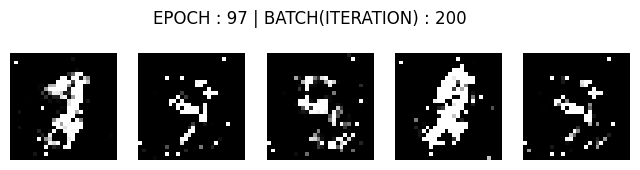

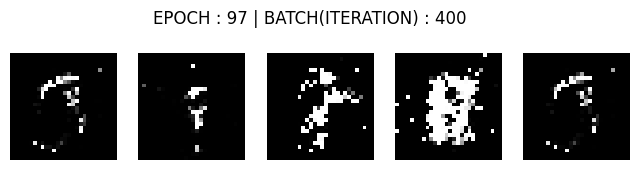

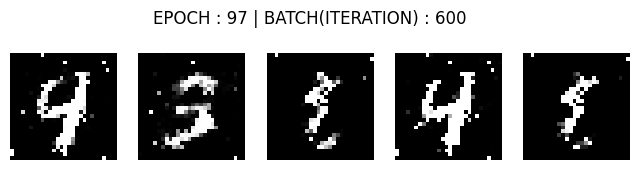

[Epoch: 97/100] [Batch: 657/657] [D loss: 0.012238] [G loss: 4.670660]


  0%|          | 0/657 [00:00<?, ?it/s]

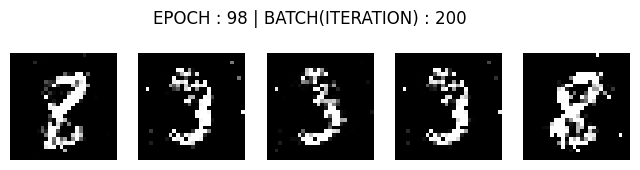

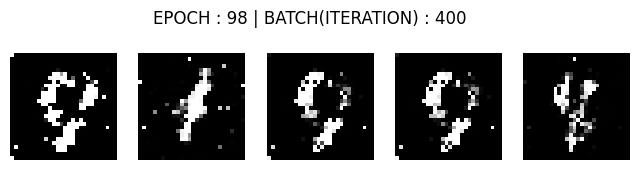

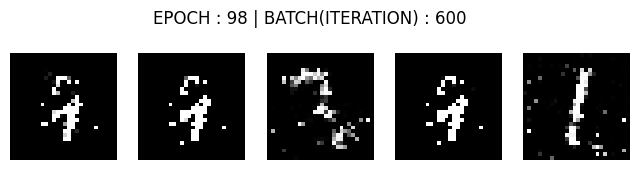

[Epoch: 98/100] [Batch: 657/657] [D loss: 0.045692] [G loss: 3.284059]


  0%|          | 0/657 [00:00<?, ?it/s]

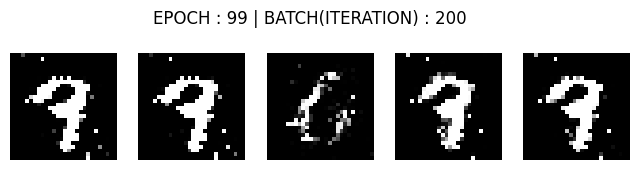

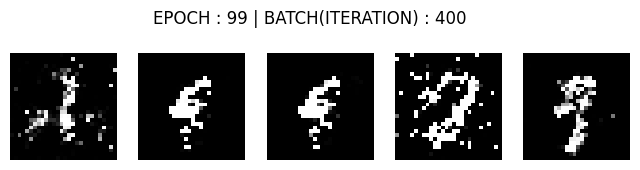

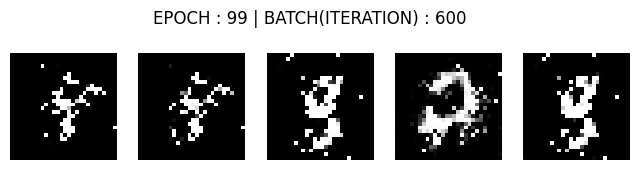

[Epoch: 99/100] [Batch: 657/657] [D loss: 0.099647] [G loss: 2.560438]


  0%|          | 0/657 [00:00<?, ?it/s]

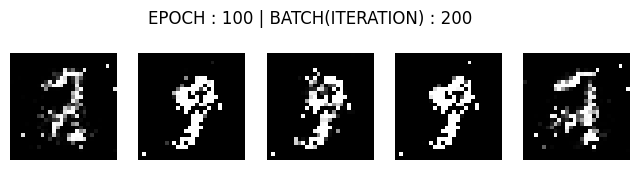

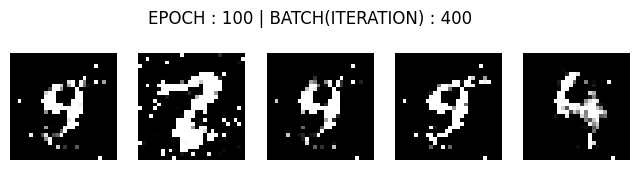

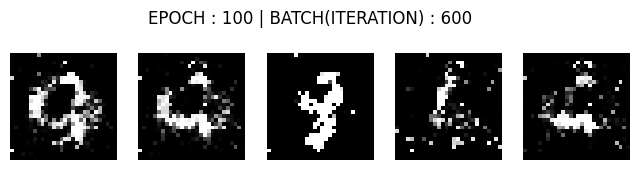

[Epoch: 100/100] [Batch: 657/657] [D loss: 0.159554] [G loss: 3.718561]


In [27]:
n_epochs = 100 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

> TEST CODE : enumerate >> [docs.python.org/enumerate](https://docs.python.org/3/library/functions.html#enumerate)

In [28]:
# result of enumerate
count = 1
for i, (imgs,label) in enumerate(dataloader):
    print('Shape of Batch Images : \n', imgs.shape)
    print('Labels (1~64) : \n', label)
    print('-'*100)
    if count == 5:
        break
    else:
        count += 1

Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([9, 8, 7, 1, 9, 0, 7, 6, 0, 7, 2, 9, 1, 1, 2, 0, 1, 5, 1, 4, 1, 7, 6, 4,
        6, 1, 8, 9, 2, 5, 1, 0, 8, 0, 9, 7, 4, 0, 2, 6, 3, 5, 2, 8, 7, 0, 3, 2,
        3, 5, 9, 6, 3, 8, 8, 8, 2, 4, 3, 1, 3, 2, 7, 7])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([1, 4, 1, 5, 9, 7, 5, 8, 0, 4, 6, 7, 4, 6, 1, 1, 4, 6, 1, 8, 2, 6, 6, 3,
        6, 1, 7, 8, 3, 2, 0, 9, 5, 7, 4, 8, 9, 2, 1, 6, 7, 3, 9, 1, 1, 5, 1, 8,
        7, 6, 5, 9, 1, 1, 4, 7, 1, 5, 0, 5, 2, 1, 5, 3])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([7, 6, 4, 4, 4, 2, 9, 0, 0, 1, 1, 4, 7, 6, 3, 7, 5, 2, 4, 5, 2, 9, 9, 0,
        2, 9, 8, 9, 9, 6, 6, 0, 2, 5, 0, 2, 7, 4, 8, 3, 6, 0, 0, 8, 

> TEST CODE :
- Read CSV file
- Tensor(imgs.size(0),1)
- Tensor(imgs.size(0),1).fill_(1.0)

In [ ]:
Tensor(10,1) # Just 10 for a quick look.
             # We dealt with Tensor(imgs.size(0),1) above. Tensor(64,1) <-- len(H) == batch_size == 64, len(W) == 1

In [ ]:
Tensor(10,1).fill_(1.0) # _ means inplace, fill the Tensor with 1.0

> TEST CODE : Variable and requires_grad

In [30]:
sample_img = next(iter(dataloader))[0]

In [31]:
sample_img.shape, sample_img.dtype

(torch.Size([64, 1, 28, 28]), torch.float32)

In [32]:
sample_img.requires_grad # default : False

False

In [ ]:
Variable(sample_img).requires_grad # exactly same

In [ ]:
sample_img.requires_grad_(True) # set requires_grad to True, _ means inplace

In [ ]:
sample_img.requires_grad # Yes. requires_grad changed correctly. you don't need wrapping tensor with Variable.

However, it can be confusing here. Obviously, the derivative is computed through the loss, but not a single `requires_grad` is set to `true`.

Remember, It's different from `model's parameter`. Internally, the parameters of each Module are stored in Tensors with `requires_grad=True` !

> TEST CODE : Ramdom Sampling (H,W) from a normal(Gaussian) distribution

In [ ]:
np.random.normal(0,1,(64,100))

In [ ]:
np.random.normal(0,1,(64,100)).shape

> TEST CODE : shape of z and gen_imgs and discriminator(gen_imgs)

In [33]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape

torch.Size([64, 100])

In [34]:
# generated images
sample_gen_imgs = generator(sample_z)
sample_gen_imgs.shape

torch.Size([64, 1, 28, 28])

In [35]:
# discrimination result
sample_discrim_result = discriminator(sample_gen_imgs)
sample_discrim_result.shape

torch.Size([64, 1])

> TEST CODE : g_loss

In [36]:
adversarial_loss

BCELoss()

In [38]:
sample_valid = Tensor(64,1).fill_(1.0)
sample_g_loss = adversarial_loss(sample_discrim_result, sample_valid)
sample_g_loss

tensor(2.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [39]:
!pip install torchviz
import torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=fa6cd72c9e34d93b75ef5378d3173c28e1618154b6fd0d639ab552a296801c34
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


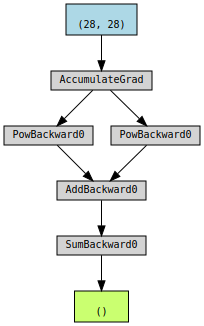

In [40]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)


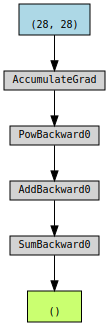

In [41]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X.detach()**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)

--------------